# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [5]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [6]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.04328005  0.24254737 -0.00955302 -0.25440812] 1 1.0 False {}
state, action, reward, done, info: [-0.0384291   0.04756311 -0.01464118  0.03524637] 0 1.0 False {}
state, action, reward, done, info: [-0.03747784 -0.14734585 -0.01393625  0.32327413] 0 1.0 False {}
state, action, reward, done, info: [-0.04042475  0.04797174 -0.00747077  0.02622906] 1 1.0 False {}
state, action, reward, done, info: [-0.03946532 -0.14704228 -0.00694619  0.31654555] 0 1.0 False {}
state, action, reward, done, info: [-0.04240616 -0.34206461 -0.00061528  0.60702981] 0 1.0 False {}
state, action, reward, done, info: [-0.04924746 -0.53717795  0.01152532  0.89951888] 0 1.0 False {}
state, action, reward, done, info: [-0.05999101 -0.73245418  0.02951569  1.19580214] 0 1.0 False {}
state, action, reward, done, info: [-0.0746401  -0.92794556  0.05343174  1.49758784] 0 1.0 False {}
state, action, reward, done, info: [-0.09319901 -0.73351216  0.08338349  1.22205542] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
        
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return actions, states, targetQs, cell, initial_state

In [9]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [10]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, final_state, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx], [self.states[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
state = env.reset()
initial_state = np.zeros([1, hidden_size])
final_state = np.zeros([1, hidden_size])
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.states.append([initial_state, final_state])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
memory.buffer[0], memory.states[0]

([array([ 0.04484891, -0.03715969, -0.01237249,  0.01858427]),
  1,
  array([ 0.04410571,  0.15813749, -0.01200081, -0.2779765 ]),
  1.0,
  0.0],
 [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])])

In [23]:
# states, rewards, actions

In [25]:
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state)

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch, rnn_states = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            next_actions_logits = sess.run(model.actions_logits, 
                                           feed_dict = {model.states: next_states, 
                                                        model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs,
                                                        model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn-seq.ckpt')

Episode:0 meanR:25.0000 R:25.0 loss:0.9614 exploreP:0.9975
Episode:1 meanR:20.5000 R:16.0 loss:1.0372 exploreP:0.9959
Episode:2 meanR:19.0000 R:16.0 loss:0.8661 exploreP:0.9944
Episode:3 meanR:24.2500 R:40.0 loss:1.2054 exploreP:0.9904
Episode:4 meanR:23.4000 R:20.0 loss:1.1202 exploreP:0.9885
Episode:5 meanR:22.0000 R:15.0 loss:0.3873 exploreP:0.9870
Episode:6 meanR:21.7143 R:20.0 loss:0.4816 exploreP:0.9851
Episode:7 meanR:22.0000 R:24.0 loss:0.8634 exploreP:0.9827
Episode:8 meanR:21.2222 R:15.0 loss:1.4622 exploreP:0.9813
Episode:9 meanR:20.5000 R:14.0 loss:2.0031 exploreP:0.9799
Episode:10 meanR:21.4545 R:31.0 loss:1.4592 exploreP:0.9769
Episode:11 meanR:20.6667 R:12.0 loss:1.4791 exploreP:0.9757
Episode:12 meanR:19.8462 R:10.0 loss:2.9227 exploreP:0.9748
Episode:13 meanR:19.1429 R:10.0 loss:3.3290 exploreP:0.9738
Episode:14 meanR:19.0000 R:17.0 loss:3.2573 exploreP:0.9722
Episode:15 meanR:19.4375 R:26.0 loss:0.7342 exploreP:0.9697
Episode:16 meanR:19.4118 R:19.0 loss:2.2238 explor

Episode:136 meanR:19.8400 R:31.0 loss:6.9841 exploreP:0.7653
Episode:137 meanR:19.8900 R:15.0 loss:11.4703 exploreP:0.7642
Episode:138 meanR:19.8600 R:12.0 loss:13.7368 exploreP:0.7633
Episode:139 meanR:19.9000 R:23.0 loss:11.6131 exploreP:0.7615
Episode:140 meanR:19.9100 R:14.0 loss:9.9076 exploreP:0.7605
Episode:141 meanR:19.8700 R:12.0 loss:14.4467 exploreP:0.7596
Episode:142 meanR:19.6500 R:18.0 loss:14.4579 exploreP:0.7582
Episode:143 meanR:19.9400 R:42.0 loss:5.2489 exploreP:0.7551
Episode:144 meanR:19.8400 R:9.0 loss:10.2327 exploreP:0.7544
Episode:145 meanR:19.8200 R:10.0 loss:17.9956 exploreP:0.7537
Episode:146 meanR:19.8500 R:16.0 loss:13.5597 exploreP:0.7525
Episode:147 meanR:19.5900 R:24.0 loss:32.3791 exploreP:0.7507
Episode:148 meanR:19.5900 R:24.0 loss:8.4303 exploreP:0.7489
Episode:149 meanR:19.6400 R:17.0 loss:18.8821 exploreP:0.7477
Episode:150 meanR:19.5300 R:11.0 loss:11.1681 exploreP:0.7469
Episode:151 meanR:19.5000 R:15.0 loss:16.0980 exploreP:0.7458
Episode:152 m

Episode:270 meanR:16.2400 R:18.0 loss:27.7216 exploreP:0.6116
Episode:271 meanR:16.0700 R:14.0 loss:10.2563 exploreP:0.6108
Episode:272 meanR:15.9600 R:9.0 loss:20.6774 exploreP:0.6102
Episode:273 meanR:15.9600 R:11.0 loss:13.1579 exploreP:0.6096
Episode:274 meanR:15.9200 R:10.0 loss:16.5524 exploreP:0.6090
Episode:275 meanR:15.7600 R:12.0 loss:20.8381 exploreP:0.6082
Episode:276 meanR:15.3300 R:12.0 loss:19.4291 exploreP:0.6075
Episode:277 meanR:15.3700 R:14.0 loss:17.6146 exploreP:0.6067
Episode:278 meanR:15.4900 R:24.0 loss:11.6209 exploreP:0.6053
Episode:279 meanR:15.4600 R:15.0 loss:9.0848 exploreP:0.6044
Episode:280 meanR:15.4400 R:11.0 loss:26.5213 exploreP:0.6037
Episode:281 meanR:15.5100 R:21.0 loss:14.2255 exploreP:0.6025
Episode:282 meanR:15.5100 R:12.0 loss:10.6876 exploreP:0.6018
Episode:283 meanR:15.5700 R:15.0 loss:33.1192 exploreP:0.6009
Episode:284 meanR:15.5700 R:10.0 loss:17.5239 exploreP:0.6003
Episode:285 meanR:15.5000 R:14.0 loss:13.6917 exploreP:0.5995
Episode:28

Episode:404 meanR:15.4700 R:13.0 loss:14.8824 exploreP:0.5018
Episode:405 meanR:15.4900 R:16.0 loss:16.3974 exploreP:0.5010
Episode:406 meanR:15.4000 R:9.0 loss:16.0089 exploreP:0.5006
Episode:407 meanR:15.3100 R:9.0 loss:22.1461 exploreP:0.5001
Episode:408 meanR:15.3200 R:15.0 loss:19.5094 exploreP:0.4994
Episode:409 meanR:15.5000 R:27.0 loss:9.5831 exploreP:0.4981
Episode:410 meanR:15.6400 R:24.0 loss:8.4120 exploreP:0.4969
Episode:411 meanR:15.6500 R:13.0 loss:11.5731 exploreP:0.4963
Episode:412 meanR:15.6500 R:10.0 loss:18.0914 exploreP:0.4958
Episode:413 meanR:15.8700 R:33.0 loss:9.4577 exploreP:0.4942
Episode:414 meanR:15.9500 R:19.0 loss:11.3792 exploreP:0.4933
Episode:415 meanR:16.0100 R:14.0 loss:12.1161 exploreP:0.4926
Episode:416 meanR:16.1600 R:43.0 loss:6.9154 exploreP:0.4905
Episode:417 meanR:16.3100 R:24.0 loss:9.1296 exploreP:0.4894
Episode:418 meanR:16.2800 R:10.0 loss:12.6706 exploreP:0.4889
Episode:419 meanR:16.3700 R:21.0 loss:15.5643 exploreP:0.4879
Episode:420 mea

Episode:537 meanR:15.2600 R:10.0 loss:15.1335 exploreP:0.4063
Episode:538 meanR:15.2300 R:18.0 loss:16.6339 exploreP:0.4056
Episode:539 meanR:15.2500 R:12.0 loss:12.5025 exploreP:0.4051
Episode:540 meanR:15.2400 R:11.0 loss:17.9682 exploreP:0.4047
Episode:541 meanR:15.2300 R:9.0 loss:20.0455 exploreP:0.4043
Episode:542 meanR:15.1900 R:11.0 loss:18.7361 exploreP:0.4039
Episode:543 meanR:15.1300 R:11.0 loss:17.3654 exploreP:0.4035
Episode:544 meanR:15.1000 R:9.0 loss:19.0378 exploreP:0.4031
Episode:545 meanR:15.1100 R:13.0 loss:17.5509 exploreP:0.4026
Episode:546 meanR:15.1200 R:12.0 loss:15.2037 exploreP:0.4021
Episode:547 meanR:15.1300 R:16.0 loss:14.2392 exploreP:0.4015
Episode:548 meanR:15.1600 R:20.0 loss:11.3858 exploreP:0.4007
Episode:549 meanR:15.2500 R:36.0 loss:9.3205 exploreP:0.3993
Episode:550 meanR:15.4100 R:40.0 loss:4.6944 exploreP:0.3978
Episode:551 meanR:15.4500 R:25.0 loss:8.4758 exploreP:0.3968
Episode:552 meanR:15.4600 R:11.0 loss:10.4633 exploreP:0.3964
Episode:553 m

Episode:670 meanR:19.6000 R:30.0 loss:9.6138 exploreP:0.3202
Episode:671 meanR:19.6100 R:14.0 loss:13.1687 exploreP:0.3198
Episode:672 meanR:19.6000 R:9.0 loss:19.4440 exploreP:0.3195
Episode:673 meanR:19.5900 R:10.0 loss:24.0929 exploreP:0.3192
Episode:674 meanR:19.6600 R:18.0 loss:17.3503 exploreP:0.3186
Episode:675 meanR:19.6600 R:10.0 loss:12.9362 exploreP:0.3183
Episode:676 meanR:19.7200 R:16.0 loss:17.0716 exploreP:0.3178
Episode:677 meanR:19.6800 R:10.0 loss:14.9540 exploreP:0.3175
Episode:678 meanR:19.6700 R:9.0 loss:21.5388 exploreP:0.3172
Episode:679 meanR:19.6600 R:9.0 loss:21.7010 exploreP:0.3170
Episode:680 meanR:19.6400 R:8.0 loss:22.9728 exploreP:0.3167
Episode:681 meanR:19.6800 R:16.0 loss:20.0047 exploreP:0.3162
Episode:682 meanR:19.7200 R:16.0 loss:12.7675 exploreP:0.3157
Episode:683 meanR:19.7600 R:14.0 loss:13.9461 exploreP:0.3153
Episode:684 meanR:19.8400 R:17.0 loss:15.3190 exploreP:0.3148
Episode:685 meanR:20.2200 R:50.0 loss:5.3263 exploreP:0.3133
Episode:686 me

Episode:803 meanR:25.5600 R:30.0 loss:12.1836 exploreP:0.2339
Episode:804 meanR:25.5400 R:34.0 loss:10.8515 exploreP:0.2331
Episode:805 meanR:25.5200 R:20.0 loss:16.5785 exploreP:0.2327
Episode:806 meanR:25.1700 R:18.0 loss:16.5962 exploreP:0.2323
Episode:807 meanR:25.0600 R:15.0 loss:17.0114 exploreP:0.2319
Episode:808 meanR:24.1700 R:14.0 loss:20.5879 exploreP:0.2316
Episode:809 meanR:23.9100 R:12.0 loss:21.9887 exploreP:0.2313
Episode:810 meanR:23.8000 R:22.0 loss:18.1655 exploreP:0.2309
Episode:811 meanR:23.6100 R:19.0 loss:15.8566 exploreP:0.2304
Episode:812 meanR:23.5500 R:13.0 loss:16.8769 exploreP:0.2301
Episode:813 meanR:23.4300 R:13.0 loss:23.2520 exploreP:0.2299
Episode:814 meanR:23.4000 R:17.0 loss:20.5552 exploreP:0.2295
Episode:815 meanR:23.1400 R:33.0 loss:11.1281 exploreP:0.2288
Episode:816 meanR:23.8300 R:89.0 loss:4.3926 exploreP:0.2268
Episode:817 meanR:24.0400 R:32.0 loss:10.9253 exploreP:0.2261
Episode:818 meanR:25.0300 R:109.0 loss:3.7042 exploreP:0.2238
Episode:8

Episode:936 meanR:27.3900 R:37.0 loss:11.9247 exploreP:0.1629
Episode:937 meanR:27.5000 R:27.0 loss:14.9050 exploreP:0.1625
Episode:938 meanR:27.4900 R:33.0 loss:13.0573 exploreP:0.1620
Episode:939 meanR:27.4700 R:25.0 loss:17.3361 exploreP:0.1617
Episode:940 meanR:26.4100 R:22.0 loss:19.1825 exploreP:0.1613
Episode:941 meanR:26.8000 R:73.0 loss:5.8828 exploreP:0.1602
Episode:942 meanR:27.4200 R:82.0 loss:6.0075 exploreP:0.1590
Episode:943 meanR:27.4600 R:35.0 loss:12.8446 exploreP:0.1585
Episode:944 meanR:28.6600 R:136.0 loss:3.9604 exploreP:0.1565
Episode:945 meanR:28.7300 R:30.0 loss:17.0255 exploreP:0.1560
Episode:946 meanR:28.7600 R:19.0 loss:23.8981 exploreP:0.1558
Episode:947 meanR:28.6000 R:17.0 loss:23.0550 exploreP:0.1555
Episode:948 meanR:28.5400 R:20.0 loss:24.6889 exploreP:0.1552
Episode:949 meanR:28.3900 R:14.0 loss:22.2698 exploreP:0.1550
Episode:950 meanR:28.2000 R:15.0 loss:27.4134 exploreP:0.1548
Episode:951 meanR:28.0700 R:25.0 loss:19.5564 exploreP:0.1544
Episode:95

Episode:1068 meanR:26.0900 R:69.0 loss:7.6703 exploreP:0.1126
Episode:1069 meanR:26.3900 R:73.0 loss:7.7078 exploreP:0.1119
Episode:1070 meanR:26.0700 R:44.0 loss:12.0611 exploreP:0.1114
Episode:1071 meanR:26.1700 R:36.0 loss:14.8023 exploreP:0.1110
Episode:1072 meanR:26.3200 R:43.0 loss:12.3898 exploreP:0.1106
Episode:1073 meanR:26.3900 R:39.0 loss:13.7586 exploreP:0.1102
Episode:1074 meanR:26.5000 R:32.0 loss:16.3376 exploreP:0.1099
Episode:1075 meanR:26.4700 R:28.0 loss:18.4196 exploreP:0.1096
Episode:1076 meanR:26.2100 R:17.0 loss:26.7162 exploreP:0.1094
Episode:1077 meanR:26.2300 R:24.0 loss:22.4316 exploreP:0.1092
Episode:1078 meanR:26.2200 R:18.0 loss:25.7157 exploreP:0.1090
Episode:1079 meanR:26.2200 R:18.0 loss:28.6127 exploreP:0.1089
Episode:1080 meanR:26.0800 R:19.0 loss:27.0205 exploreP:0.1087
Episode:1081 meanR:25.9500 R:13.0 loss:26.0827 exploreP:0.1085
Episode:1082 meanR:25.7800 R:17.0 loss:31.8662 exploreP:0.1084
Episode:1083 meanR:25.7800 R:17.0 loss:26.1842 exploreP:0

Episode:1199 meanR:34.3500 R:21.0 loss:27.3821 exploreP:0.0770
Episode:1200 meanR:34.2500 R:16.0 loss:28.8186 exploreP:0.0769
Episode:1201 meanR:34.2300 R:17.0 loss:33.7876 exploreP:0.0767
Episode:1202 meanR:34.2200 R:29.0 loss:21.0582 exploreP:0.0765
Episode:1203 meanR:34.2700 R:38.0 loss:15.5090 exploreP:0.0763
Episode:1204 meanR:34.7400 R:70.0 loss:8.7143 exploreP:0.0758
Episode:1205 meanR:34.8400 R:48.0 loss:12.7262 exploreP:0.0755
Episode:1206 meanR:34.7400 R:34.0 loss:16.6016 exploreP:0.0753
Episode:1207 meanR:34.8000 R:30.0 loss:20.4048 exploreP:0.0751
Episode:1208 meanR:34.6600 R:29.0 loss:20.3435 exploreP:0.0749
Episode:1209 meanR:34.6300 R:25.0 loss:22.9333 exploreP:0.0747
Episode:1210 meanR:34.5300 R:22.0 loss:22.9574 exploreP:0.0746
Episode:1211 meanR:34.5600 R:29.0 loss:19.5739 exploreP:0.0744
Episode:1212 meanR:34.3100 R:18.0 loss:29.0889 exploreP:0.0743
Episode:1213 meanR:33.4800 R:25.0 loss:22.0484 exploreP:0.0741
Episode:1214 meanR:33.3100 R:30.0 loss:18.8470 exploreP:

Episode:1330 meanR:38.4700 R:27.0 loss:23.7873 exploreP:0.0508
Episode:1331 meanR:37.9700 R:29.0 loss:20.5437 exploreP:0.0507
Episode:1332 meanR:37.3100 R:26.0 loss:23.2119 exploreP:0.0506
Episode:1333 meanR:37.2300 R:34.0 loss:17.2243 exploreP:0.0504
Episode:1334 meanR:38.0100 R:106.0 loss:6.3023 exploreP:0.0500
Episode:1335 meanR:38.9900 R:126.0 loss:5.7116 exploreP:0.0495
Episode:1336 meanR:39.8500 R:111.0 loss:7.2652 exploreP:0.0491
Episode:1337 meanR:39.9300 R:31.0 loss:24.9752 exploreP:0.0490
Episode:1338 meanR:39.7500 R:21.0 loss:35.1544 exploreP:0.0489
Episode:1339 meanR:39.6300 R:106.0 loss:7.5079 exploreP:0.0485
Episode:1340 meanR:39.6500 R:36.0 loss:22.4669 exploreP:0.0483
Episode:1341 meanR:39.0300 R:23.0 loss:30.2674 exploreP:0.0482
Episode:1342 meanR:38.4400 R:24.0 loss:27.7737 exploreP:0.0481
Episode:1343 meanR:38.1800 R:26.0 loss:24.6237 exploreP:0.0480
Episode:1344 meanR:37.9900 R:18.0 loss:33.1538 exploreP:0.0480
Episode:1345 meanR:37.4700 R:16.0 loss:33.1310 exploreP

Episode:1461 meanR:27.9600 R:23.0 loss:28.0913 exploreP:0.0381
Episode:1462 meanR:28.9400 R:107.0 loss:5.7729 exploreP:0.0378
Episode:1463 meanR:29.0300 R:19.0 loss:34.7186 exploreP:0.0377
Episode:1464 meanR:30.5000 R:157.0 loss:4.3326 exploreP:0.0373
Episode:1465 meanR:30.8000 R:44.0 loss:16.1876 exploreP:0.0372
Episode:1466 meanR:30.9100 R:25.0 loss:25.0744 exploreP:0.0371
Episode:1467 meanR:30.9400 R:19.0 loss:29.1114 exploreP:0.0371
Episode:1468 meanR:31.0000 R:18.0 loss:27.7216 exploreP:0.0370
Episode:1469 meanR:31.0400 R:16.0 loss:29.2979 exploreP:0.0370
Episode:1470 meanR:31.1600 R:21.0 loss:26.5280 exploreP:0.0369
Episode:1471 meanR:31.3500 R:30.0 loss:16.7199 exploreP:0.0368
Episode:1472 meanR:32.2000 R:98.0 loss:5.8842 exploreP:0.0366
Episode:1473 meanR:32.6100 R:53.0 loss:11.2037 exploreP:0.0364
Episode:1474 meanR:33.1700 R:66.0 loss:9.1900 exploreP:0.0362
Episode:1475 meanR:33.4700 R:40.0 loss:15.4651 exploreP:0.0361
Episode:1476 meanR:33.6000 R:22.0 loss:30.5395 exploreP:0

Episode:1592 meanR:67.7000 R:87.0 loss:13.6840 exploreP:0.0220
Episode:1593 meanR:68.2700 R:100.0 loss:11.6947 exploreP:0.0218
Episode:1594 meanR:69.9700 R:189.0 loss:6.8170 exploreP:0.0216
Episode:1595 meanR:70.0300 R:20.0 loss:50.2128 exploreP:0.0216
Episode:1596 meanR:70.9700 R:109.0 loss:10.6528 exploreP:0.0215
Episode:1597 meanR:72.5400 R:173.0 loss:8.0869 exploreP:0.0213
Episode:1598 meanR:74.0400 R:165.0 loss:6.3514 exploreP:0.0211
Episode:1599 meanR:75.2400 R:137.0 loss:8.7334 exploreP:0.0209
Episode:1600 meanR:75.6900 R:59.0 loss:19.9329 exploreP:0.0209
Episode:1601 meanR:74.9500 R:30.0 loss:50.5894 exploreP:0.0208
Episode:1602 meanR:74.2300 R:27.0 loss:49.6247 exploreP:0.0208
Episode:1603 meanR:74.3100 R:38.0 loss:33.3501 exploreP:0.0208
Episode:1604 meanR:77.4600 R:338.0 loss:3.7743 exploreP:0.0204
Episode:1605 meanR:77.5700 R:52.0 loss:29.8532 exploreP:0.0204
Episode:1606 meanR:77.6100 R:98.0 loss:14.8987 exploreP:0.0203
Episode:1607 meanR:77.4000 R:24.0 loss:37.6478 explor

Episode:1723 meanR:29.2900 R:98.0 loss:5.3766 exploreP:0.0167
Episode:1724 meanR:29.2900 R:19.0 loss:55.3543 exploreP:0.0167
Episode:1725 meanR:30.2500 R:115.0 loss:8.1822 exploreP:0.0166
Episode:1726 meanR:30.2900 R:22.0 loss:50.9965 exploreP:0.0166
Episode:1727 meanR:30.3100 R:19.0 loss:24.6344 exploreP:0.0166
Episode:1728 meanR:29.8800 R:13.0 loss:23.6793 exploreP:0.0166
Episode:1729 meanR:29.5400 R:18.0 loss:27.7858 exploreP:0.0166
Episode:1730 meanR:30.4000 R:130.0 loss:4.2694 exploreP:0.0165
Episode:1731 meanR:30.2900 R:23.0 loss:49.6070 exploreP:0.0165
Episode:1732 meanR:30.3300 R:35.0 loss:24.2144 exploreP:0.0165
Episode:1733 meanR:30.4800 R:33.0 loss:25.4379 exploreP:0.0165
Episode:1734 meanR:31.4500 R:116.0 loss:7.4334 exploreP:0.0164
Episode:1735 meanR:31.5600 R:26.0 loss:43.3419 exploreP:0.0164
Episode:1736 meanR:33.0000 R:160.0 loss:3.4612 exploreP:0.0163
Episode:1737 meanR:33.1200 R:24.0 loss:51.6830 exploreP:0.0162
Episode:1738 meanR:33.2900 R:33.0 loss:27.3381 exploreP:

Episode:1853 meanR:89.6200 R:32.0 loss:29.5380 exploreP:0.0123
Episode:1854 meanR:91.2200 R:210.0 loss:4.6086 exploreP:0.0123
Episode:1855 meanR:91.7100 R:75.0 loss:11.6121 exploreP:0.0123
Episode:1856 meanR:91.5100 R:109.0 loss:11.5995 exploreP:0.0122
Episode:1857 meanR:91.7100 R:123.0 loss:17.0779 exploreP:0.0122
Episode:1858 meanR:93.2700 R:187.0 loss:9.6838 exploreP:0.0122
Episode:1859 meanR:92.6200 R:97.0 loss:13.0340 exploreP:0.0121
Episode:1860 meanR:93.2400 R:99.0 loss:22.7459 exploreP:0.0121
Episode:1861 meanR:94.1400 R:143.0 loss:9.3588 exploreP:0.0121
Episode:1862 meanR:94.4200 R:57.0 loss:33.2627 exploreP:0.0121
Episode:1863 meanR:95.3700 R:130.0 loss:13.9283 exploreP:0.0121
Episode:1864 meanR:95.6200 R:62.0 loss:31.5280 exploreP:0.0120
Episode:1865 meanR:96.7000 R:136.0 loss:14.1369 exploreP:0.0120
Episode:1866 meanR:97.4800 R:105.0 loss:17.8593 exploreP:0.0120
Episode:1867 meanR:98.0200 R:207.0 loss:9.3776 exploreP:0.0120
Episode:1868 meanR:99.3300 R:153.0 loss:14.0571 ex

Episode:1981 meanR:234.9300 R:359.0 loss:0.9352 exploreP:0.0101
Episode:1982 meanR:234.4900 R:182.0 loss:4.0224 exploreP:0.0101
Episode:1983 meanR:238.4400 R:500.0 loss:1.0881 exploreP:0.0101
Episode:1984 meanR:243.3100 R:500.0 loss:3.3984 exploreP:0.0101
Episode:1985 meanR:247.0000 R:500.0 loss:11.0814 exploreP:0.0101
Episode:1986 meanR:249.0300 R:395.0 loss:15.0341 exploreP:0.0101
Episode:1987 meanR:248.3300 R:159.0 loss:4.0110 exploreP:0.0101
Episode:1988 meanR:250.4300 R:229.0 loss:2.5817 exploreP:0.0101
Episode:1989 meanR:252.3200 R:199.0 loss:3.6203 exploreP:0.0101
Episode:1990 meanR:253.1500 R:104.0 loss:13.9677 exploreP:0.0101
Episode:1991 meanR:254.1600 R:158.0 loss:3.9295 exploreP:0.0101
Episode:1992 meanR:255.6700 R:242.0 loss:4.0195 exploreP:0.0101
Episode:1993 meanR:254.7500 R:135.0 loss:4.4711 exploreP:0.0101
Episode:1994 meanR:254.5300 R:248.0 loss:1.7388 exploreP:0.0101
Episode:1995 meanR:253.2400 R:142.0 loss:2.4504 exploreP:0.0101
Episode:1996 meanR:254.7000 R:160.0 l

Episode:2109 meanR:373.0200 R:500.0 loss:2.0782 exploreP:0.0100
Episode:2110 meanR:373.6500 R:104.0 loss:59.3559 exploreP:0.0100
Episode:2111 meanR:373.6500 R:500.0 loss:4.3662 exploreP:0.0100
Episode:2112 meanR:373.6500 R:500.0 loss:13.7185 exploreP:0.0100
Episode:2113 meanR:373.6500 R:500.0 loss:8.3877 exploreP:0.0100
Episode:2114 meanR:378.4100 R:500.0 loss:12.1105 exploreP:0.0100
Episode:2115 meanR:378.4100 R:500.0 loss:10.8395 exploreP:0.0100
Episode:2116 meanR:380.7000 R:500.0 loss:10.5767 exploreP:0.0100
Episode:2117 meanR:380.7000 R:500.0 loss:13.1727 exploreP:0.0100
Episode:2118 meanR:383.2500 R:500.0 loss:12.3540 exploreP:0.0100
Episode:2119 meanR:383.2500 R:500.0 loss:4.3527 exploreP:0.0100
Episode:2120 meanR:383.2500 R:500.0 loss:6.5501 exploreP:0.0100
Episode:2121 meanR:383.2500 R:500.0 loss:7.6977 exploreP:0.0100
Episode:2122 meanR:379.1300 R:88.0 loss:56.5727 exploreP:0.0100
Episode:2123 meanR:379.1300 R:500.0 loss:3.6743 exploreP:0.0100
Episode:2124 meanR:379.1300 R:500

Episode:2236 meanR:481.6500 R:500.0 loss:12.2781 exploreP:0.0100
Episode:2237 meanR:476.7800 R:13.0 loss:328.6572 exploreP:0.0100
Episode:2238 meanR:476.7800 R:500.0 loss:15.4137 exploreP:0.0100
Episode:2239 meanR:478.8700 R:500.0 loss:15.5114 exploreP:0.0100
Episode:2240 meanR:482.7400 R:500.0 loss:15.3338 exploreP:0.0100
Episode:2241 meanR:479.6200 R:12.0 loss:321.8780 exploreP:0.0100
Episode:2242 meanR:482.4000 R:500.0 loss:15.5351 exploreP:0.0100
Episode:2243 meanR:485.4400 R:500.0 loss:17.9188 exploreP:0.0100
Episode:2244 meanR:485.4400 R:500.0 loss:15.6532 exploreP:0.0100
Episode:2245 meanR:485.4400 R:500.0 loss:11.9161 exploreP:0.0100
Episode:2246 meanR:480.5600 R:12.0 loss:361.4533 exploreP:0.0100
Episode:2247 meanR:480.5600 R:500.0 loss:14.8529 exploreP:0.0100
Episode:2248 meanR:480.5600 R:500.0 loss:13.0160 exploreP:0.0100
Episode:2249 meanR:475.8500 R:29.0 loss:218.4364 exploreP:0.0100
Episode:2250 meanR:475.8500 R:500.0 loss:11.9272 exploreP:0.0100
Episode:2251 meanR:475.85

Episode:2363 meanR:45.5800 R:12.0 loss:627.8365 exploreP:0.0100
Episode:2364 meanR:40.6800 R:10.0 loss:639.7761 exploreP:0.0100
Episode:2365 meanR:35.7700 R:9.0 loss:449.4649 exploreP:0.0100
Episode:2366 meanR:35.7500 R:9.0 loss:751.0530 exploreP:0.0100
Episode:2367 meanR:35.7500 R:11.0 loss:1014.9219 exploreP:0.0100
Episode:2368 meanR:30.8500 R:10.0 loss:1336.1951 exploreP:0.0100
Episode:2369 meanR:30.8400 R:9.0 loss:1333.0994 exploreP:0.0100
Episode:2370 meanR:25.9300 R:9.0 loss:1407.0212 exploreP:0.0100
Episode:2371 meanR:21.0300 R:10.0 loss:1275.9265 exploreP:0.0100
Episode:2372 meanR:21.0500 R:12.0 loss:793.6238 exploreP:0.0100
Episode:2373 meanR:21.0700 R:12.0 loss:418.0009 exploreP:0.0100
Episode:2374 meanR:21.0500 R:9.0 loss:775.8104 exploreP:0.0100
Episode:2375 meanR:16.1400 R:9.0 loss:826.2268 exploreP:0.0100
Episode:2376 meanR:16.1600 R:11.0 loss:761.0157 exploreP:0.0100
Episode:2377 meanR:16.1700 R:10.0 loss:530.7955 exploreP:0.0100
Episode:2378 meanR:16.1500 R:10.0 loss:40

Episode:2495 meanR:9.6600 R:10.0 loss:578.6719 exploreP:0.0100
Episode:2496 meanR:9.6600 R:9.0 loss:743.3437 exploreP:0.0100
Episode:2497 meanR:9.6800 R:11.0 loss:611.3293 exploreP:0.0100
Episode:2498 meanR:9.7000 R:11.0 loss:457.8791 exploreP:0.0100
Episode:2499 meanR:9.7000 R:9.0 loss:541.3118 exploreP:0.0100
Episode:2500 meanR:9.6900 R:9.0 loss:665.5518 exploreP:0.0100
Episode:2501 meanR:9.7000 R:10.0 loss:612.4380 exploreP:0.0100
Episode:2502 meanR:9.6900 R:9.0 loss:651.1035 exploreP:0.0100
Episode:2503 meanR:9.7100 R:11.0 loss:605.4815 exploreP:0.0100
Episode:2504 meanR:9.7100 R:10.0 loss:383.6659 exploreP:0.0100
Episode:2505 meanR:9.7200 R:11.0 loss:451.8666 exploreP:0.0100
Episode:2506 meanR:9.7300 R:10.0 loss:470.3300 exploreP:0.0100
Episode:2507 meanR:9.7400 R:11.0 loss:613.2170 exploreP:0.0100
Episode:2508 meanR:9.7300 R:10.0 loss:568.6302 exploreP:0.0100
Episode:2509 meanR:9.7500 R:11.0 loss:426.0412 exploreP:0.0100
Episode:2510 meanR:9.7500 R:10.0 loss:438.7925 exploreP:0.0

Episode:2625 meanR:28.1300 R:500.0 loss:1.5539 exploreP:0.0100
Episode:2626 meanR:28.1700 R:15.0 loss:24.8186 exploreP:0.0100
Episode:2627 meanR:32.7400 R:500.0 loss:1.7374 exploreP:0.0100
Episode:2628 meanR:37.4200 R:500.0 loss:10.4298 exploreP:0.0100
Episode:2629 meanR:41.9800 R:500.0 loss:14.4315 exploreP:0.0100
Episode:2630 meanR:46.5700 R:500.0 loss:24.0709 exploreP:0.0100
Episode:2631 meanR:51.1200 R:500.0 loss:14.6361 exploreP:0.0100
Episode:2632 meanR:50.6000 R:18.0 loss:1291.6958 exploreP:0.0100
Episode:2633 meanR:55.4800 R:500.0 loss:19.8372 exploreP:0.0100
Episode:2634 meanR:60.3300 R:500.0 loss:20.4127 exploreP:0.0100
Episode:2635 meanR:64.9800 R:500.0 loss:15.2640 exploreP:0.0100
Episode:2636 meanR:69.6500 R:500.0 loss:14.5598 exploreP:0.0100
Episode:2637 meanR:74.1700 R:500.0 loss:15.8585 exploreP:0.0100
Episode:2638 meanR:78.7900 R:500.0 loss:16.2653 exploreP:0.0100
Episode:2639 meanR:83.1900 R:500.0 loss:16.8516 exploreP:0.0100
Episode:2640 meanR:87.8400 R:500.0 loss:16

Episode:2752 meanR:490.4300 R:500.0 loss:14.0085 exploreP:0.0100
Episode:2753 meanR:490.4300 R:500.0 loss:11.9111 exploreP:0.0100
Episode:2754 meanR:490.4300 R:500.0 loss:13.8373 exploreP:0.0100
Episode:2755 meanR:490.4300 R:500.0 loss:14.7926 exploreP:0.0100
Episode:2756 meanR:490.4300 R:500.0 loss:11.6905 exploreP:0.0100
Episode:2757 meanR:490.4300 R:500.0 loss:8.9471 exploreP:0.0100
Episode:2758 meanR:490.4300 R:500.0 loss:12.8842 exploreP:0.0100
Episode:2759 meanR:490.4300 R:500.0 loss:12.4620 exploreP:0.0100
Episode:2760 meanR:490.4300 R:500.0 loss:12.5712 exploreP:0.0100
Episode:2761 meanR:490.4300 R:500.0 loss:15.8924 exploreP:0.0100
Episode:2762 meanR:490.4300 R:500.0 loss:13.3261 exploreP:0.0100
Episode:2763 meanR:490.4300 R:500.0 loss:10.0993 exploreP:0.0100
Episode:2764 meanR:490.4300 R:500.0 loss:11.0368 exploreP:0.0100
Episode:2765 meanR:490.4300 R:500.0 loss:10.2510 exploreP:0.0100
Episode:2766 meanR:490.4300 R:500.0 loss:8.8520 exploreP:0.0100
Episode:2767 meanR:490.4300

Episode:2878 meanR:198.7700 R:500.0 loss:15.8330 exploreP:0.0100
Episode:2879 meanR:198.7700 R:500.0 loss:17.0256 exploreP:0.0100
Episode:2880 meanR:198.7700 R:500.0 loss:26.6458 exploreP:0.0100
Episode:2881 meanR:198.7700 R:500.0 loss:14.6749 exploreP:0.0100
Episode:2882 meanR:198.7700 R:500.0 loss:16.8254 exploreP:0.0100
Episode:2883 meanR:198.7700 R:500.0 loss:16.5131 exploreP:0.0100
Episode:2884 meanR:198.7700 R:500.0 loss:15.9893 exploreP:0.0100
Episode:2885 meanR:198.7700 R:500.0 loss:19.2054 exploreP:0.0100
Episode:2886 meanR:198.7700 R:500.0 loss:15.5667 exploreP:0.0100
Episode:2887 meanR:203.6400 R:500.0 loss:16.1249 exploreP:0.0100
Episode:2888 meanR:208.5200 R:500.0 loss:16.0130 exploreP:0.0100
Episode:2889 meanR:208.5200 R:500.0 loss:14.2668 exploreP:0.0100
Episode:2890 meanR:213.4100 R:500.0 loss:12.1367 exploreP:0.0100
Episode:2891 meanR:218.3000 R:500.0 loss:13.7578 exploreP:0.0100
Episode:2892 meanR:223.1800 R:500.0 loss:15.1166 exploreP:0.0100
Episode:2893 meanR:228.05

Episode:3005 meanR:446.6000 R:500.0 loss:11.4051 exploreP:0.0100
Episode:3006 meanR:441.7300 R:13.0 loss:361.4377 exploreP:0.0100
Episode:3007 meanR:441.7300 R:500.0 loss:15.3711 exploreP:0.0100
Episode:3008 meanR:436.8400 R:11.0 loss:333.0454 exploreP:0.0100
Episode:3009 meanR:431.9500 R:11.0 loss:367.7099 exploreP:0.0100
Episode:3010 meanR:431.9500 R:500.0 loss:11.2813 exploreP:0.0100
Episode:3011 meanR:431.9500 R:500.0 loss:15.0339 exploreP:0.0100
Episode:3012 meanR:431.9500 R:500.0 loss:15.0553 exploreP:0.0100
Episode:3013 meanR:431.9500 R:500.0 loss:16.4500 exploreP:0.0100
Episode:3014 meanR:431.9500 R:500.0 loss:12.4113 exploreP:0.0100
Episode:3015 meanR:431.9500 R:500.0 loss:17.3413 exploreP:0.0100
Episode:3016 meanR:431.9500 R:500.0 loss:13.6528 exploreP:0.0100
Episode:3017 meanR:431.9500 R:500.0 loss:13.0055 exploreP:0.0100
Episode:3018 meanR:431.9500 R:500.0 loss:17.4372 exploreP:0.0100
Episode:3019 meanR:431.9500 R:500.0 loss:12.5935 exploreP:0.0100
Episode:3020 meanR:427.06

Episode:3133 meanR:421.1500 R:500.0 loss:2.2100 exploreP:0.0100
Episode:3134 meanR:421.1500 R:500.0 loss:1.6759 exploreP:0.0100
Episode:3135 meanR:421.1500 R:500.0 loss:2.5174 exploreP:0.0100
Episode:3136 meanR:421.1500 R:500.0 loss:3.1260 exploreP:0.0100
Episode:3137 meanR:416.9100 R:76.0 loss:61.2265 exploreP:0.0100
Episode:3138 meanR:414.8900 R:298.0 loss:30.5539 exploreP:0.0100
Episode:3139 meanR:414.1000 R:421.0 loss:19.1308 exploreP:0.0100
Episode:3140 meanR:414.1000 R:500.0 loss:13.3775 exploreP:0.0100
Episode:3141 meanR:410.9400 R:184.0 loss:21.9812 exploreP:0.0100
Episode:3142 meanR:407.4100 R:147.0 loss:36.0660 exploreP:0.0100
Episode:3143 meanR:409.0600 R:177.0 loss:24.3504 exploreP:0.0100
Episode:3144 meanR:409.0600 R:500.0 loss:8.6580 exploreP:0.0100
Episode:3145 meanR:409.0600 R:500.0 loss:6.7839 exploreP:0.0100
Episode:3146 meanR:409.0600 R:500.0 loss:15.4446 exploreP:0.0100
Episode:3147 meanR:409.0600 R:500.0 loss:14.0062 exploreP:0.0100
Episode:3148 meanR:409.0600 R:50

Episode:3260 meanR:187.7300 R:53.0 loss:131.7051 exploreP:0.0100
Episode:3261 meanR:183.1600 R:43.0 loss:106.2579 exploreP:0.0100
Episode:3262 meanR:178.7400 R:58.0 loss:148.2656 exploreP:0.0100
Episode:3263 meanR:174.0700 R:33.0 loss:428.5121 exploreP:0.0100
Episode:3264 meanR:169.4600 R:39.0 loss:469.9693 exploreP:0.0100
Episode:3265 meanR:169.4600 R:500.0 loss:13.7219 exploreP:0.0100
Episode:3266 meanR:169.4600 R:500.0 loss:9.5792 exploreP:0.0100
Episode:3267 meanR:169.4600 R:500.0 loss:5.6530 exploreP:0.0100
Episode:3268 meanR:169.4600 R:500.0 loss:16.8237 exploreP:0.0100
Episode:3269 meanR:169.4600 R:500.0 loss:5.6300 exploreP:0.0100
Episode:3270 meanR:169.4600 R:500.0 loss:6.1972 exploreP:0.0100
Episode:3271 meanR:171.4000 R:500.0 loss:7.5210 exploreP:0.0100
Episode:3272 meanR:167.4800 R:108.0 loss:27.3837 exploreP:0.0100
Episode:3273 meanR:167.4800 R:500.0 loss:14.0743 exploreP:0.0100
Episode:3274 meanR:170.1000 R:500.0 loss:5.0028 exploreP:0.0100
Episode:3275 meanR:170.1000 R:5

Episode:3386 meanR:277.1300 R:18.0 loss:1633.1801 exploreP:0.0100
Episode:3387 meanR:272.3500 R:22.0 loss:1780.8796 exploreP:0.0100
Episode:3388 meanR:267.5600 R:21.0 loss:2123.0925 exploreP:0.0100
Episode:3389 meanR:262.7000 R:14.0 loss:1754.9249 exploreP:0.0100
Episode:3390 meanR:258.0300 R:33.0 loss:1977.2498 exploreP:0.0100
Episode:3391 meanR:253.1700 R:14.0 loss:2214.7449 exploreP:0.0100
Episode:3392 meanR:248.3000 R:13.0 loss:1767.6228 exploreP:0.0100
Episode:3393 meanR:243.4600 R:16.0 loss:1697.3567 exploreP:0.0100
Episode:3394 meanR:238.6500 R:19.0 loss:1272.4637 exploreP:0.0100
Episode:3395 meanR:233.8100 R:16.0 loss:1816.7664 exploreP:0.0100
Episode:3396 meanR:229.0000 R:19.0 loss:1849.1040 exploreP:0.0100
Episode:3397 meanR:224.1900 R:19.0 loss:1331.6071 exploreP:0.0100
Episode:3398 meanR:219.3900 R:20.0 loss:1963.8385 exploreP:0.0100
Episode:3399 meanR:214.5300 R:14.0 loss:2219.6628 exploreP:0.0100
Episode:3400 meanR:209.6700 R:14.0 loss:2225.4856 exploreP:0.0100
Episode:34

Episode:3513 meanR:18.8300 R:14.0 loss:1487.1847 exploreP:0.0100
Episode:3514 meanR:18.7600 R:13.0 loss:1686.6196 exploreP:0.0100
Episode:3515 meanR:19.2600 R:71.0 loss:1033.7946 exploreP:0.0100
Episode:3516 meanR:19.1100 R:17.0 loss:1778.1892 exploreP:0.0100
Episode:3517 meanR:18.9600 R:12.0 loss:1860.7496 exploreP:0.0100
Episode:3518 meanR:18.9200 R:13.0 loss:1693.4407 exploreP:0.0100
Episode:3519 meanR:18.8800 R:13.0 loss:1688.9556 exploreP:0.0100
Episode:3520 meanR:18.8500 R:13.0 loss:1443.9595 exploreP:0.0100
Episode:3521 meanR:18.8200 R:14.0 loss:1853.7604 exploreP:0.0100
Episode:3522 meanR:21.6200 R:293.0 loss:294.4668 exploreP:0.0100
Episode:3523 meanR:21.7300 R:24.0 loss:1604.1185 exploreP:0.0100
Episode:3524 meanR:24.0200 R:246.0 loss:239.2728 exploreP:0.0100
Episode:3525 meanR:24.0000 R:15.0 loss:1987.1030 exploreP:0.0100
Episode:3526 meanR:23.9900 R:13.0 loss:2632.7566 exploreP:0.0100
Episode:3527 meanR:23.9500 R:17.0 loss:1333.5886 exploreP:0.0100
Episode:3528 meanR:23.790

Episode:3639 meanR:14.4800 R:14.0 loss:1879.9465 exploreP:0.0100
Episode:3640 meanR:14.4500 R:12.0 loss:1620.9165 exploreP:0.0100
Episode:3641 meanR:14.4200 R:15.0 loss:2269.3037 exploreP:0.0100
Episode:3642 meanR:14.4000 R:11.0 loss:3439.0500 exploreP:0.0100
Episode:3643 meanR:14.3400 R:11.0 loss:2739.2156 exploreP:0.0100
Episode:3644 meanR:14.3300 R:13.0 loss:1607.3279 exploreP:0.0100
Episode:3645 meanR:14.3500 R:14.0 loss:1460.3793 exploreP:0.0100
Episode:3646 meanR:14.3100 R:13.0 loss:1587.0437 exploreP:0.0100
Episode:3647 meanR:14.3200 R:15.0 loss:2387.5134 exploreP:0.0100
Episode:3648 meanR:14.3600 R:16.0 loss:3892.5068 exploreP:0.0100
Episode:3649 meanR:14.3300 R:12.0 loss:3833.6716 exploreP:0.0100
Episode:3650 meanR:14.2800 R:12.0 loss:2596.8210 exploreP:0.0100
Episode:3651 meanR:14.2700 R:16.0 loss:1686.4435 exploreP:0.0100
Episode:3652 meanR:14.2600 R:12.0 loss:1824.2958 exploreP:0.0100
Episode:3653 meanR:14.2800 R:14.0 loss:1518.9869 exploreP:0.0100
Episode:3654 meanR:14.270

Episode:3766 meanR:19.6600 R:17.0 loss:2470.4087 exploreP:0.0100
Episode:3767 meanR:19.6700 R:12.0 loss:2230.5149 exploreP:0.0100
Episode:3768 meanR:19.6800 R:14.0 loss:2074.6267 exploreP:0.0100
Episode:3769 meanR:19.7100 R:14.0 loss:2265.5120 exploreP:0.0100
Episode:3770 meanR:19.8500 R:29.0 loss:2760.8228 exploreP:0.0100
Episode:3771 meanR:19.8800 R:14.0 loss:3692.2678 exploreP:0.0100
Episode:3772 meanR:19.8700 R:11.0 loss:1541.4282 exploreP:0.0100
Episode:3773 meanR:19.8500 R:13.0 loss:2105.0732 exploreP:0.0100
Episode:3774 meanR:19.8200 R:13.0 loss:2510.7615 exploreP:0.0100
Episode:3775 meanR:19.7900 R:14.0 loss:2385.0964 exploreP:0.0100
Episode:3776 meanR:19.7800 R:13.0 loss:2462.2527 exploreP:0.0100
Episode:3777 meanR:19.8000 R:14.0 loss:3723.7351 exploreP:0.0100
Episode:3778 meanR:19.7800 R:13.0 loss:2261.5400 exploreP:0.0100
Episode:3779 meanR:19.7900 R:12.0 loss:2189.9875 exploreP:0.0100
Episode:3780 meanR:19.8100 R:13.0 loss:1981.8933 exploreP:0.0100
Episode:3781 meanR:19.830

Episode:3894 meanR:13.6800 R:13.0 loss:1954.3829 exploreP:0.0100
Episode:3895 meanR:13.6200 R:12.0 loss:2914.7214 exploreP:0.0100
Episode:3896 meanR:13.6900 R:19.0 loss:3724.1101 exploreP:0.0100
Episode:3897 meanR:13.7900 R:21.0 loss:2609.0955 exploreP:0.0100
Episode:3898 meanR:13.8300 R:15.0 loss:2683.1709 exploreP:0.0100
Episode:3899 meanR:13.8200 R:11.0 loss:1768.6597 exploreP:0.0100
Episode:3900 meanR:13.8100 R:13.0 loss:1631.2483 exploreP:0.0100
Episode:3901 meanR:13.8300 R:12.0 loss:1435.4222 exploreP:0.0100
Episode:3902 meanR:13.8100 R:11.0 loss:1600.7255 exploreP:0.0100
Episode:3903 meanR:13.8300 R:13.0 loss:3038.8567 exploreP:0.0100
Episode:3904 meanR:13.8500 R:12.0 loss:3400.4250 exploreP:0.0100
Episode:3905 meanR:13.8200 R:11.0 loss:4138.0356 exploreP:0.0100
Episode:3906 meanR:13.7600 R:11.0 loss:3150.2625 exploreP:0.0100
Episode:3907 meanR:13.7500 R:15.0 loss:4141.9229 exploreP:0.0100
Episode:3908 meanR:13.7200 R:12.0 loss:2553.6218 exploreP:0.0100
Episode:3909 meanR:13.890

Episode:4021 meanR:12.1500 R:10.0 loss:4373.6641 exploreP:0.0100
Episode:4022 meanR:12.1500 R:12.0 loss:3230.0452 exploreP:0.0100
Episode:4023 meanR:12.1600 R:12.0 loss:3876.4534 exploreP:0.0100
Episode:4024 meanR:12.1700 R:13.0 loss:4150.6792 exploreP:0.0100
Episode:4025 meanR:12.1700 R:12.0 loss:3753.2773 exploreP:0.0100
Episode:4026 meanR:12.1500 R:10.0 loss:3916.6296 exploreP:0.0100
Episode:4027 meanR:12.1500 R:12.0 loss:3568.3943 exploreP:0.0100
Episode:4028 meanR:12.1500 R:12.0 loss:1976.9838 exploreP:0.0100
Episode:4029 meanR:12.1400 R:11.0 loss:2662.2698 exploreP:0.0100
Episode:4030 meanR:12.1700 R:15.0 loss:4098.6909 exploreP:0.0100
Episode:4031 meanR:12.1800 R:12.0 loss:2149.2017 exploreP:0.0100
Episode:4032 meanR:12.1800 R:12.0 loss:2910.4338 exploreP:0.0100
Episode:4033 meanR:12.1800 R:12.0 loss:3203.9421 exploreP:0.0100
Episode:4034 meanR:12.1800 R:12.0 loss:1801.3993 exploreP:0.0100
Episode:4035 meanR:12.1700 R:14.0 loss:1505.4617 exploreP:0.0100
Episode:4036 meanR:12.160

Episode:4148 meanR:12.1500 R:11.0 loss:3346.9617 exploreP:0.0100
Episode:4149 meanR:12.1600 R:11.0 loss:3425.6533 exploreP:0.0100
Episode:4150 meanR:12.1600 R:15.0 loss:4110.1328 exploreP:0.0100
Episode:4151 meanR:12.1400 R:10.0 loss:3985.5962 exploreP:0.0100
Episode:4152 meanR:12.1300 R:11.0 loss:3664.8760 exploreP:0.0100
Episode:4153 meanR:12.1500 R:15.0 loss:3414.9036 exploreP:0.0100
Episode:4154 meanR:12.1500 R:12.0 loss:3720.9207 exploreP:0.0100
Episode:4155 meanR:12.1700 R:13.0 loss:3554.7544 exploreP:0.0100
Episode:4156 meanR:12.1600 R:11.0 loss:3461.8455 exploreP:0.0100
Episode:4157 meanR:12.1600 R:13.0 loss:4225.8706 exploreP:0.0100
Episode:4158 meanR:12.1400 R:10.0 loss:4612.3345 exploreP:0.0100
Episode:4159 meanR:12.1400 R:12.0 loss:3595.5842 exploreP:0.0100
Episode:4160 meanR:12.1200 R:10.0 loss:3442.1938 exploreP:0.0100
Episode:4161 meanR:12.1300 R:11.0 loss:3473.3557 exploreP:0.0100
Episode:4162 meanR:12.1900 R:18.0 loss:3290.6257 exploreP:0.0100
Episode:4163 meanR:12.170

Episode:4275 meanR:11.8200 R:11.0 loss:2969.3694 exploreP:0.0100
Episode:4276 meanR:11.8100 R:12.0 loss:3083.5520 exploreP:0.0100
Episode:4277 meanR:11.8200 R:13.0 loss:3091.2903 exploreP:0.0100
Episode:4278 meanR:11.8000 R:13.0 loss:3167.5300 exploreP:0.0100
Episode:4279 meanR:11.8100 R:11.0 loss:3270.5920 exploreP:0.0100
Episode:4280 meanR:11.7900 R:11.0 loss:2872.5681 exploreP:0.0100
Episode:4281 meanR:11.8000 R:13.0 loss:2685.3596 exploreP:0.0100
Episode:4282 meanR:11.8000 R:11.0 loss:3103.0283 exploreP:0.0100
Episode:4283 meanR:11.8100 R:12.0 loss:3008.7087 exploreP:0.0100
Episode:4284 meanR:11.8000 R:12.0 loss:3034.9534 exploreP:0.0100
Episode:4285 meanR:11.8200 R:12.0 loss:3045.7441 exploreP:0.0100
Episode:4286 meanR:11.8300 R:13.0 loss:2613.3774 exploreP:0.0100
Episode:4287 meanR:11.8200 R:11.0 loss:2724.8279 exploreP:0.0100
Episode:4288 meanR:11.8000 R:13.0 loss:2738.2913 exploreP:0.0100
Episode:4289 meanR:11.7900 R:11.0 loss:3114.8181 exploreP:0.0100
Episode:4290 meanR:11.800

Episode:4403 meanR:12.3300 R:13.0 loss:2569.7900 exploreP:0.0100
Episode:4404 meanR:12.3400 R:13.0 loss:2428.3958 exploreP:0.0100
Episode:4405 meanR:12.3400 R:13.0 loss:2525.1091 exploreP:0.0100
Episode:4406 meanR:12.3500 R:13.0 loss:2915.9749 exploreP:0.0100
Episode:4407 meanR:12.3900 R:14.0 loss:2705.1426 exploreP:0.0100
Episode:4408 meanR:12.4100 R:14.0 loss:2617.3308 exploreP:0.0100
Episode:4409 meanR:12.4200 R:11.0 loss:2646.7725 exploreP:0.0100
Episode:4410 meanR:12.4200 R:13.0 loss:2838.1182 exploreP:0.0100
Episode:4411 meanR:12.4400 R:13.0 loss:2436.5979 exploreP:0.0100
Episode:4412 meanR:12.4500 R:14.0 loss:2605.5110 exploreP:0.0100
Episode:4413 meanR:12.4800 R:14.0 loss:2583.5566 exploreP:0.0100
Episode:4414 meanR:12.4800 R:12.0 loss:2431.6707 exploreP:0.0100
Episode:4415 meanR:12.4800 R:13.0 loss:2797.9119 exploreP:0.0100
Episode:4416 meanR:12.4900 R:12.0 loss:2789.9314 exploreP:0.0100
Episode:4417 meanR:12.4700 R:10.0 loss:2955.4224 exploreP:0.0100
Episode:4418 meanR:12.440

Episode:4531 meanR:12.2900 R:14.0 loss:2594.4353 exploreP:0.0100
Episode:4532 meanR:12.3200 R:13.0 loss:2445.9924 exploreP:0.0100
Episode:4533 meanR:12.3600 R:14.0 loss:2492.3306 exploreP:0.0100
Episode:4534 meanR:12.3900 R:13.0 loss:2543.3455 exploreP:0.0100
Episode:4535 meanR:12.3900 R:13.0 loss:2245.5974 exploreP:0.0100
Episode:4536 meanR:12.3700 R:10.0 loss:2364.5989 exploreP:0.0100
Episode:4537 meanR:12.3700 R:13.0 loss:2816.9116 exploreP:0.0100
Episode:4538 meanR:12.3900 R:14.0 loss:2472.1987 exploreP:0.0100
Episode:4539 meanR:12.4000 R:13.0 loss:2383.4563 exploreP:0.0100
Episode:4540 meanR:12.4100 R:14.0 loss:2256.8508 exploreP:0.0100
Episode:4541 meanR:12.3800 R:10.0 loss:2756.9380 exploreP:0.0100
Episode:4542 meanR:12.4000 R:12.0 loss:2763.7664 exploreP:0.0100
Episode:4543 meanR:12.3800 R:12.0 loss:2622.5364 exploreP:0.0100
Episode:4544 meanR:12.3500 R:10.0 loss:2826.5349 exploreP:0.0100
Episode:4545 meanR:12.3500 R:14.0 loss:2744.3254 exploreP:0.0100
Episode:4546 meanR:12.370

Episode:4658 meanR:12.1200 R:12.0 loss:2595.4084 exploreP:0.0100
Episode:4659 meanR:12.0700 R:10.0 loss:2589.1509 exploreP:0.0100
Episode:4660 meanR:12.0300 R:10.0 loss:2950.3787 exploreP:0.0100
Episode:4661 meanR:12.0300 R:10.0 loss:3034.5471 exploreP:0.0100
Episode:4662 meanR:12.0600 R:13.0 loss:2757.3918 exploreP:0.0100
Episode:4663 meanR:12.0500 R:12.0 loss:2436.0735 exploreP:0.0100
Episode:4664 meanR:12.0700 R:14.0 loss:2591.5723 exploreP:0.0100
Episode:4665 meanR:12.0400 R:10.0 loss:2669.6189 exploreP:0.0100
Episode:4666 meanR:12.0600 R:14.0 loss:2893.5959 exploreP:0.0100
Episode:4667 meanR:12.0300 R:10.0 loss:2742.3853 exploreP:0.0100
Episode:4668 meanR:12.0500 R:14.0 loss:2571.5034 exploreP:0.0100
Episode:4669 meanR:12.0300 R:11.0 loss:2603.9446 exploreP:0.0100
Episode:4670 meanR:12.0100 R:12.0 loss:3162.0061 exploreP:0.0100
Episode:4671 meanR:12.0400 R:14.0 loss:2887.6704 exploreP:0.0100
Episode:4672 meanR:12.0800 R:14.0 loss:2357.2112 exploreP:0.0100
Episode:4673 meanR:12.060

Episode:4785 meanR:12.2100 R:12.0 loss:2532.1250 exploreP:0.0100
Episode:4786 meanR:12.2000 R:10.0 loss:2686.0505 exploreP:0.0100
Episode:4787 meanR:12.2000 R:13.0 loss:2731.0798 exploreP:0.0100
Episode:4788 meanR:12.1700 R:10.0 loss:2641.0242 exploreP:0.0100
Episode:4789 meanR:12.1800 R:11.0 loss:2700.9292 exploreP:0.0100
Episode:4790 meanR:12.1900 R:13.0 loss:2550.1196 exploreP:0.0100
Episode:4791 meanR:12.1700 R:10.0 loss:2668.5364 exploreP:0.0100
Episode:4792 meanR:12.1700 R:13.0 loss:2620.9441 exploreP:0.0100
Episode:4793 meanR:12.2100 R:14.0 loss:2370.8186 exploreP:0.0100
Episode:4794 meanR:12.2100 R:13.0 loss:2451.4341 exploreP:0.0100
Episode:4795 meanR:12.2100 R:12.0 loss:2438.4138 exploreP:0.0100
Episode:4796 meanR:12.2000 R:13.0 loss:2462.1584 exploreP:0.0100
Episode:4797 meanR:12.1900 R:12.0 loss:2730.7390 exploreP:0.0100
Episode:4798 meanR:12.2000 R:14.0 loss:2595.8027 exploreP:0.0100
Episode:4799 meanR:12.2200 R:14.0 loss:2849.0750 exploreP:0.0100
Episode:4800 meanR:12.200

Episode:4913 meanR:12.2300 R:14.0 loss:2679.4924 exploreP:0.0100
Episode:4914 meanR:12.2000 R:10.0 loss:2522.4255 exploreP:0.0100
Episode:4915 meanR:12.2100 R:13.0 loss:2722.3386 exploreP:0.0100
Episode:4916 meanR:12.1700 R:10.0 loss:2826.1099 exploreP:0.0100
Episode:4917 meanR:12.1400 R:10.0 loss:2917.8330 exploreP:0.0100
Episode:4918 meanR:12.1300 R:13.0 loss:2799.1787 exploreP:0.0100
Episode:4919 meanR:12.1000 R:10.0 loss:2733.3071 exploreP:0.0100
Episode:4920 meanR:12.0800 R:11.0 loss:2655.6370 exploreP:0.0100
Episode:4921 meanR:12.0600 R:10.0 loss:2822.2048 exploreP:0.0100
Episode:4922 meanR:12.0600 R:12.0 loss:2760.8103 exploreP:0.0100
Episode:4923 meanR:12.0600 R:12.0 loss:2847.3186 exploreP:0.0100
Episode:4924 meanR:12.0600 R:13.0 loss:2443.1311 exploreP:0.0100
Episode:4925 meanR:12.0700 R:13.0 loss:2207.6560 exploreP:0.0100
Episode:4926 meanR:12.0600 R:11.0 loss:2202.5283 exploreP:0.0100
Episode:4927 meanR:12.0300 R:11.0 loss:2641.1184 exploreP:0.0100
Episode:4928 meanR:12.000

Episode:5040 meanR:12.1000 R:10.0 loss:2501.2622 exploreP:0.0100
Episode:5041 meanR:12.1300 R:13.0 loss:2532.4976 exploreP:0.0100
Episode:5042 meanR:12.1700 R:14.0 loss:2589.2058 exploreP:0.0100
Episode:5043 meanR:12.1800 R:12.0 loss:2593.5789 exploreP:0.0100
Episode:5044 meanR:12.1500 R:13.0 loss:2503.5549 exploreP:0.0100
Episode:5045 meanR:12.1500 R:13.0 loss:2157.5715 exploreP:0.0100
Episode:5046 meanR:12.1700 R:13.0 loss:2313.9319 exploreP:0.0100
Episode:5047 meanR:12.1900 R:12.0 loss:2501.3235 exploreP:0.0100
Episode:5048 meanR:12.1600 R:10.0 loss:2778.7283 exploreP:0.0100
Episode:5049 meanR:12.1700 R:13.0 loss:2793.4597 exploreP:0.0100
Episode:5050 meanR:12.1700 R:10.0 loss:2932.1917 exploreP:0.0100
Episode:5051 meanR:12.2000 R:13.0 loss:2591.7588 exploreP:0.0100
Episode:5052 meanR:12.1800 R:11.0 loss:2824.1904 exploreP:0.0100
Episode:5053 meanR:12.2100 R:16.0 loss:2843.5620 exploreP:0.0100
Episode:5054 meanR:12.2200 R:14.0 loss:2637.5022 exploreP:0.0100
Episode:5055 meanR:12.250

Episode:5167 meanR:12.0500 R:12.0 loss:2555.6755 exploreP:0.0100
Episode:5168 meanR:12.0900 R:16.0 loss:2428.3247 exploreP:0.0100
Episode:5169 meanR:12.0600 R:12.0 loss:2373.9800 exploreP:0.0100
Episode:5170 meanR:12.0800 R:14.0 loss:2509.2856 exploreP:0.0100
Episode:5171 meanR:12.0700 R:12.0 loss:2476.5007 exploreP:0.0100
Episode:5172 meanR:12.0900 R:12.0 loss:2516.3264 exploreP:0.0100
Episode:5173 meanR:12.0700 R:12.0 loss:2408.8157 exploreP:0.0100
Episode:5174 meanR:12.1000 R:13.0 loss:2723.9363 exploreP:0.0100
Episode:5175 meanR:12.1000 R:13.0 loss:2732.7717 exploreP:0.0100
Episode:5176 meanR:12.1200 R:13.0 loss:2423.1924 exploreP:0.0100
Episode:5177 meanR:12.0900 R:10.0 loss:2438.1187 exploreP:0.0100
Episode:5178 meanR:12.0900 R:12.0 loss:2921.8074 exploreP:0.0100
Episode:5179 meanR:12.0900 R:11.0 loss:2812.5181 exploreP:0.0100
Episode:5180 meanR:12.1100 R:12.0 loss:2677.4138 exploreP:0.0100
Episode:5181 meanR:12.1100 R:13.0 loss:2635.0889 exploreP:0.0100
Episode:5182 meanR:12.130

Episode:5294 meanR:11.9600 R:14.0 loss:2466.0945 exploreP:0.0100
Episode:5295 meanR:11.9500 R:13.0 loss:2356.3445 exploreP:0.0100
Episode:5296 meanR:11.9500 R:12.0 loss:2469.6272 exploreP:0.0100
Episode:5297 meanR:11.9500 R:12.0 loss:2498.9724 exploreP:0.0100
Episode:5298 meanR:11.9400 R:12.0 loss:2076.4875 exploreP:0.0100
Episode:5299 meanR:11.9700 R:14.0 loss:2511.0991 exploreP:0.0100
Episode:5300 meanR:11.9800 R:13.0 loss:2512.6941 exploreP:0.0100
Episode:5301 meanR:11.9500 R:11.0 loss:2636.0815 exploreP:0.0100
Episode:5302 meanR:11.9600 R:14.0 loss:2561.5886 exploreP:0.0100
Episode:5303 meanR:11.9700 R:11.0 loss:2313.1404 exploreP:0.0100
Episode:5304 meanR:11.9400 R:10.0 loss:2775.7764 exploreP:0.0100
Episode:5305 meanR:11.9500 R:12.0 loss:2923.8767 exploreP:0.0100
Episode:5306 meanR:11.9600 R:13.0 loss:2606.8994 exploreP:0.0100
Episode:5307 meanR:11.9200 R:10.0 loss:2541.4917 exploreP:0.0100
Episode:5308 meanR:11.9400 R:12.0 loss:2739.7092 exploreP:0.0100
Episode:5309 meanR:11.970

Episode:5422 meanR:12.0100 R:12.0 loss:2765.8176 exploreP:0.0100
Episode:5423 meanR:12.0100 R:13.0 loss:2312.3308 exploreP:0.0100
Episode:5424 meanR:11.9700 R:10.0 loss:2261.8110 exploreP:0.0100
Episode:5425 meanR:11.9400 R:10.0 loss:2801.7168 exploreP:0.0100
Episode:5426 meanR:11.9800 R:14.0 loss:2747.3513 exploreP:0.0100
Episode:5427 meanR:11.9600 R:12.0 loss:2263.7314 exploreP:0.0100
Episode:5428 meanR:11.9600 R:12.0 loss:2524.0059 exploreP:0.0100
Episode:5429 meanR:11.9400 R:10.0 loss:2738.3979 exploreP:0.0100
Episode:5430 meanR:11.9200 R:10.0 loss:2809.4399 exploreP:0.0100
Episode:5431 meanR:11.9100 R:12.0 loss:2773.7590 exploreP:0.0100
Episode:5432 meanR:11.9200 R:12.0 loss:2340.5730 exploreP:0.0100
Episode:5433 meanR:11.9000 R:10.0 loss:2633.1333 exploreP:0.0100
Episode:5434 meanR:11.9100 R:14.0 loss:2873.6184 exploreP:0.0100
Episode:5435 meanR:11.9200 R:14.0 loss:2417.3674 exploreP:0.0100
Episode:5436 meanR:11.9500 R:13.0 loss:2347.0588 exploreP:0.0100
Episode:5437 meanR:11.940

Episode:5549 meanR:12.4100 R:13.0 loss:2564.3394 exploreP:0.0100
Episode:5550 meanR:12.4100 R:10.0 loss:2615.0425 exploreP:0.0100
Episode:5551 meanR:12.4200 R:13.0 loss:2732.4207 exploreP:0.0100
Episode:5552 meanR:12.4100 R:12.0 loss:2568.1516 exploreP:0.0100
Episode:5553 meanR:12.3800 R:10.0 loss:2800.9915 exploreP:0.0100
Episode:5554 meanR:12.3800 R:13.0 loss:2806.9028 exploreP:0.0100
Episode:5555 meanR:12.3700 R:12.0 loss:2567.9768 exploreP:0.0100
Episode:5556 meanR:12.3600 R:13.0 loss:2898.9229 exploreP:0.0100
Episode:5557 meanR:12.3800 R:13.0 loss:2268.7769 exploreP:0.0100
Episode:5558 meanR:12.3800 R:12.0 loss:2208.8115 exploreP:0.0100
Episode:5559 meanR:12.3800 R:13.0 loss:2309.5044 exploreP:0.0100
Episode:5560 meanR:12.3900 R:14.0 loss:2327.4807 exploreP:0.0100
Episode:5561 meanR:12.3700 R:10.0 loss:2566.7852 exploreP:0.0100
Episode:5562 meanR:12.3800 R:13.0 loss:2998.9985 exploreP:0.0100
Episode:5563 meanR:12.3800 R:13.0 loss:2696.1655 exploreP:0.0100
Episode:5564 meanR:12.360

Episode:5676 meanR:12.2600 R:14.0 loss:2483.9297 exploreP:0.0100
Episode:5677 meanR:12.2600 R:13.0 loss:2323.3428 exploreP:0.0100
Episode:5678 meanR:12.2700 R:14.0 loss:2329.9519 exploreP:0.0100
Episode:5679 meanR:12.2600 R:12.0 loss:2428.2729 exploreP:0.0100
Episode:5680 meanR:12.2600 R:14.0 loss:2461.8669 exploreP:0.0100
Episode:5681 meanR:12.2600 R:13.0 loss:2491.9380 exploreP:0.0100
Episode:5682 meanR:12.2800 R:12.0 loss:2198.2415 exploreP:0.0100
Episode:5683 meanR:12.2600 R:10.0 loss:2096.3330 exploreP:0.0100
Episode:5684 meanR:12.2700 R:11.0 loss:2833.1028 exploreP:0.0100
Episode:5685 meanR:12.2600 R:12.0 loss:3103.1248 exploreP:0.0100
Episode:5686 meanR:12.2500 R:12.0 loss:3049.6729 exploreP:0.0100
Episode:5687 meanR:12.2400 R:10.0 loss:2809.5027 exploreP:0.0100
Episode:5688 meanR:12.2300 R:10.0 loss:2859.6809 exploreP:0.0100
Episode:5689 meanR:12.2600 R:13.0 loss:2744.5869 exploreP:0.0100
Episode:5690 meanR:12.2500 R:11.0 loss:2359.2979 exploreP:0.0100
Episode:5691 meanR:12.220

Episode:5804 meanR:12.1700 R:14.0 loss:2441.3337 exploreP:0.0100
Episode:5805 meanR:12.1900 R:13.0 loss:2450.2729 exploreP:0.0100
Episode:5806 meanR:12.2000 R:14.0 loss:2325.9480 exploreP:0.0100
Episode:5807 meanR:12.2000 R:12.0 loss:2713.9685 exploreP:0.0100
Episode:5808 meanR:12.2400 R:14.0 loss:2789.1477 exploreP:0.0100
Episode:5809 meanR:12.2500 R:14.0 loss:2426.3418 exploreP:0.0100
Episode:5810 meanR:12.2200 R:10.0 loss:2824.7864 exploreP:0.0100
Episode:5811 meanR:12.2200 R:12.0 loss:2697.0322 exploreP:0.0100
Episode:5812 meanR:12.2500 R:13.0 loss:2281.9429 exploreP:0.0100
Episode:5813 meanR:12.2400 R:12.0 loss:2332.4614 exploreP:0.0100
Episode:5814 meanR:12.2200 R:12.0 loss:2630.4031 exploreP:0.0100
Episode:5815 meanR:12.2100 R:11.0 loss:2945.0225 exploreP:0.0100
Episode:5816 meanR:12.2100 R:10.0 loss:3081.3047 exploreP:0.0100
Episode:5817 meanR:12.2100 R:12.0 loss:2993.9851 exploreP:0.0100
Episode:5818 meanR:12.1800 R:10.0 loss:2448.9094 exploreP:0.0100
Episode:5819 meanR:12.170

Episode:5931 meanR:12.2300 R:12.0 loss:2748.1663 exploreP:0.0100
Episode:5932 meanR:12.2500 R:13.0 loss:2380.5544 exploreP:0.0100
Episode:5933 meanR:12.2700 R:12.0 loss:2391.0354 exploreP:0.0100
Episode:5934 meanR:12.2700 R:11.0 loss:2680.6780 exploreP:0.0100
Episode:5935 meanR:12.2400 R:10.0 loss:3089.5137 exploreP:0.0100
Episode:5936 meanR:12.2200 R:10.0 loss:2949.9761 exploreP:0.0100
Episode:5937 meanR:12.2500 R:13.0 loss:2347.6199 exploreP:0.0100
Episode:5938 meanR:12.2600 R:13.0 loss:2066.4177 exploreP:0.0100
Episode:5939 meanR:12.2400 R:10.0 loss:2458.4741 exploreP:0.0100
Episode:5940 meanR:12.2100 R:10.0 loss:2751.5190 exploreP:0.0100
Episode:5941 meanR:12.2000 R:12.0 loss:2830.8311 exploreP:0.0100
Episode:5942 meanR:12.2200 R:14.0 loss:2550.9177 exploreP:0.0100
Episode:5943 meanR:12.2100 R:12.0 loss:2416.1169 exploreP:0.0100
Episode:5944 meanR:12.2100 R:12.0 loss:2588.9971 exploreP:0.0100
Episode:5945 meanR:12.1800 R:10.0 loss:2706.5688 exploreP:0.0100
Episode:5946 meanR:12.200

Episode:6059 meanR:12.2000 R:12.0 loss:2676.1160 exploreP:0.0100
Episode:6060 meanR:12.2100 R:13.0 loss:2776.7346 exploreP:0.0100
Episode:6061 meanR:12.1800 R:10.0 loss:2757.0405 exploreP:0.0100
Episode:6062 meanR:12.1700 R:12.0 loss:2974.3340 exploreP:0.0100
Episode:6063 meanR:12.1500 R:11.0 loss:2981.8142 exploreP:0.0100
Episode:6064 meanR:12.1100 R:10.0 loss:3040.8530 exploreP:0.0100
Episode:6065 meanR:12.1300 R:15.0 loss:2576.8589 exploreP:0.0100
Episode:6066 meanR:12.1300 R:11.0 loss:2375.3618 exploreP:0.0100
Episode:6067 meanR:12.1300 R:13.0 loss:2704.1797 exploreP:0.0100
Episode:6068 meanR:12.1400 R:14.0 loss:2460.4021 exploreP:0.0100
Episode:6069 meanR:12.1600 R:12.0 loss:2545.5693 exploreP:0.0100
Episode:6070 meanR:12.1700 R:13.0 loss:2480.2007 exploreP:0.0100
Episode:6071 meanR:12.1500 R:10.0 loss:2290.4175 exploreP:0.0100
Episode:6072 meanR:12.1700 R:13.0 loss:2684.1616 exploreP:0.0100
Episode:6073 meanR:12.2300 R:16.0 loss:2242.9158 exploreP:0.0100
Episode:6074 meanR:12.260

Episode:6187 meanR:12.1800 R:13.0 loss:2640.5012 exploreP:0.0100
Episode:6188 meanR:12.1900 R:14.0 loss:2145.2200 exploreP:0.0100
Episode:6189 meanR:12.1800 R:13.0 loss:2070.5237 exploreP:0.0100
Episode:6190 meanR:12.1800 R:10.0 loss:2680.0356 exploreP:0.0100
Episode:6191 meanR:12.1600 R:12.0 loss:2862.2158 exploreP:0.0100
Episode:6192 meanR:12.1700 R:14.0 loss:2563.8689 exploreP:0.0100
Episode:6193 meanR:12.1500 R:12.0 loss:2692.7058 exploreP:0.0100
Episode:6194 meanR:12.1700 R:14.0 loss:2758.6841 exploreP:0.0100
Episode:6195 meanR:12.1900 R:12.0 loss:2534.9753 exploreP:0.0100
Episode:6196 meanR:12.2000 R:13.0 loss:2502.7000 exploreP:0.0100
Episode:6197 meanR:12.1700 R:10.0 loss:2645.8848 exploreP:0.0100
Episode:6198 meanR:12.1700 R:12.0 loss:2867.2068 exploreP:0.0100
Episode:6199 meanR:12.1600 R:12.0 loss:2802.7712 exploreP:0.0100
Episode:6200 meanR:12.1500 R:12.0 loss:2843.6689 exploreP:0.0100
Episode:6201 meanR:12.1500 R:12.0 loss:2765.3535 exploreP:0.0100
Episode:6202 meanR:12.160

Episode:6315 meanR:12.0800 R:10.0 loss:2410.8882 exploreP:0.0100
Episode:6316 meanR:12.1100 R:13.0 loss:2835.1873 exploreP:0.0100
Episode:6317 meanR:12.1000 R:12.0 loss:2727.5137 exploreP:0.0100
Episode:6318 meanR:12.1300 R:14.0 loss:2515.1699 exploreP:0.0100
Episode:6319 meanR:12.1300 R:13.0 loss:2330.0935 exploreP:0.0100
Episode:6320 meanR:12.1400 R:14.0 loss:2270.7124 exploreP:0.0100
Episode:6321 meanR:12.1400 R:11.0 loss:2717.3694 exploreP:0.0100
Episode:6322 meanR:12.1400 R:12.0 loss:2552.8103 exploreP:0.0100
Episode:6323 meanR:12.1900 R:15.0 loss:2405.8237 exploreP:0.0100
Episode:6324 meanR:12.1900 R:12.0 loss:2277.0117 exploreP:0.0100
Episode:6325 meanR:12.1900 R:12.0 loss:2685.2151 exploreP:0.0100
Episode:6326 meanR:12.2400 R:15.0 loss:2628.4292 exploreP:0.0100
Episode:6327 meanR:12.2100 R:10.0 loss:2696.2334 exploreP:0.0100
Episode:6328 meanR:12.2300 R:12.0 loss:2793.9895 exploreP:0.0100
Episode:6329 meanR:12.2300 R:12.0 loss:2749.5959 exploreP:0.0100
Episode:6330 meanR:12.220

Episode:6442 meanR:12.2900 R:10.0 loss:2515.3809 exploreP:0.0100
Episode:6443 meanR:12.2800 R:12.0 loss:2741.2363 exploreP:0.0100
Episode:6444 meanR:12.2800 R:12.0 loss:2220.9651 exploreP:0.0100
Episode:6445 meanR:12.2800 R:12.0 loss:2496.5371 exploreP:0.0100
Episode:6446 meanR:12.3200 R:15.0 loss:2431.9375 exploreP:0.0100
Episode:6447 meanR:12.3600 R:14.0 loss:2577.8435 exploreP:0.0100
Episode:6448 meanR:12.3700 R:13.0 loss:2585.2139 exploreP:0.0100
Episode:6449 meanR:12.3600 R:12.0 loss:2419.8318 exploreP:0.0100
Episode:6450 meanR:12.3400 R:11.0 loss:2603.8005 exploreP:0.0100
Episode:6451 meanR:12.3400 R:13.0 loss:2495.8298 exploreP:0.0100
Episode:6452 meanR:12.3600 R:13.0 loss:2669.1306 exploreP:0.0100
Episode:6453 meanR:12.3800 R:14.0 loss:2528.0393 exploreP:0.0100
Episode:6454 meanR:12.3700 R:12.0 loss:2470.8899 exploreP:0.0100
Episode:6455 meanR:12.3400 R:11.0 loss:2693.8506 exploreP:0.0100
Episode:6456 meanR:12.3500 R:13.0 loss:2600.6060 exploreP:0.0100
Episode:6457 meanR:12.370

Episode:6570 meanR:11.7900 R:13.0 loss:2782.1521 exploreP:0.0100
Episode:6571 meanR:11.7900 R:12.0 loss:2858.7422 exploreP:0.0100
Episode:6572 meanR:11.8200 R:13.0 loss:2858.8303 exploreP:0.0100
Episode:6573 meanR:11.8600 R:14.0 loss:2469.9829 exploreP:0.0100
Episode:6574 meanR:11.8700 R:13.0 loss:2289.9106 exploreP:0.0100
Episode:6575 meanR:11.8900 R:13.0 loss:2330.9365 exploreP:0.0100
Episode:6576 meanR:11.8400 R:10.0 loss:2609.1079 exploreP:0.0100
Episode:6577 meanR:11.8500 R:11.0 loss:2805.0496 exploreP:0.0100
Episode:6578 meanR:11.8400 R:12.0 loss:2555.6921 exploreP:0.0100
Episode:6579 meanR:11.8500 R:12.0 loss:2672.8879 exploreP:0.0100
Episode:6580 meanR:11.8400 R:12.0 loss:2673.3665 exploreP:0.0100
Episode:6581 meanR:11.8200 R:10.0 loss:2576.1423 exploreP:0.0100
Episode:6582 meanR:11.8600 R:16.0 loss:2492.7441 exploreP:0.0100
Episode:6583 meanR:11.8900 R:13.0 loss:2313.6389 exploreP:0.0100
Episode:6584 meanR:11.9000 R:13.0 loss:2332.0815 exploreP:0.0100
Episode:6585 meanR:11.930

Episode:6697 meanR:11.9600 R:13.0 loss:2688.6489 exploreP:0.0100
Episode:6698 meanR:11.9700 R:12.0 loss:2383.3188 exploreP:0.0100
Episode:6699 meanR:11.9600 R:13.0 loss:2266.7114 exploreP:0.0100
Episode:6700 meanR:11.9800 R:13.0 loss:2207.2534 exploreP:0.0100
Episode:6701 meanR:11.9500 R:10.0 loss:2527.8140 exploreP:0.0100
Episode:6702 meanR:11.9300 R:10.0 loss:2819.5786 exploreP:0.0100
Episode:6703 meanR:11.9000 R:10.0 loss:2929.8982 exploreP:0.0100
Episode:6704 meanR:11.9100 R:13.0 loss:2623.9644 exploreP:0.0100
Episode:6705 meanR:11.9200 R:11.0 loss:2567.4153 exploreP:0.0100
Episode:6706 meanR:11.9600 R:15.0 loss:2539.9639 exploreP:0.0100
Episode:6707 meanR:11.9800 R:12.0 loss:2532.8860 exploreP:0.0100
Episode:6708 meanR:11.9600 R:12.0 loss:2569.4514 exploreP:0.0100
Episode:6709 meanR:11.9600 R:13.0 loss:2734.7971 exploreP:0.0100
Episode:6710 meanR:11.9300 R:10.0 loss:2586.3359 exploreP:0.0100
Episode:6711 meanR:11.9200 R:12.0 loss:2606.1436 exploreP:0.0100
Episode:6712 meanR:11.910

Episode:6825 meanR:12.0100 R:10.0 loss:2842.0786 exploreP:0.0100
Episode:6826 meanR:12.0200 R:12.0 loss:2688.4856 exploreP:0.0100
Episode:6827 meanR:12.0000 R:12.0 loss:2573.9353 exploreP:0.0100
Episode:6828 meanR:11.9900 R:12.0 loss:2611.6943 exploreP:0.0100
Episode:6829 meanR:12.0200 R:13.0 loss:2522.2698 exploreP:0.0100
Episode:6830 meanR:12.0400 R:14.0 loss:2284.4158 exploreP:0.0100
Episode:6831 meanR:12.0400 R:10.0 loss:2598.4377 exploreP:0.0100
Episode:6832 meanR:12.0500 R:14.0 loss:2457.4275 exploreP:0.0100
Episode:6833 meanR:12.0700 R:12.0 loss:2370.4204 exploreP:0.0100
Episode:6834 meanR:12.0800 R:13.0 loss:2604.7656 exploreP:0.0100
Episode:6835 meanR:12.1000 R:13.0 loss:2313.9971 exploreP:0.0100
Episode:6836 meanR:12.1100 R:13.0 loss:1948.9149 exploreP:0.0100
Episode:6837 meanR:12.0800 R:11.0 loss:2306.8171 exploreP:0.0100
Episode:6838 meanR:12.0700 R:13.0 loss:2212.0120 exploreP:0.0100
Episode:6839 meanR:12.0600 R:11.0 loss:2259.9800 exploreP:0.0100
Episode:6840 meanR:12.070

Episode:6953 meanR:12.0600 R:12.0 loss:2552.5315 exploreP:0.0100
Episode:6954 meanR:12.0600 R:13.0 loss:2647.2107 exploreP:0.0100
Episode:6955 meanR:12.0900 R:14.0 loss:2501.6421 exploreP:0.0100
Episode:6956 meanR:12.1000 R:13.0 loss:2515.0601 exploreP:0.0100
Episode:6957 meanR:12.0900 R:10.0 loss:2886.8701 exploreP:0.0100
Episode:6958 meanR:12.0700 R:10.0 loss:3090.7778 exploreP:0.0100
Episode:6959 meanR:12.0800 R:13.0 loss:2844.3394 exploreP:0.0100
Episode:6960 meanR:12.1000 R:14.0 loss:2590.2502 exploreP:0.0100
Episode:6961 meanR:12.1000 R:13.0 loss:2252.3064 exploreP:0.0100
Episode:6962 meanR:12.1100 R:13.0 loss:2045.5143 exploreP:0.0100
Episode:6963 meanR:12.0800 R:10.0 loss:2308.3472 exploreP:0.0100
Episode:6964 meanR:12.0500 R:10.0 loss:2891.6079 exploreP:0.0100
Episode:6965 meanR:12.0600 R:13.0 loss:2811.4905 exploreP:0.0100
Episode:6966 meanR:12.0500 R:11.0 loss:2383.1736 exploreP:0.0100
Episode:6967 meanR:12.0300 R:12.0 loss:2546.2534 exploreP:0.0100
Episode:6968 meanR:12.040

Episode:7081 meanR:11.9700 R:10.0 loss:2337.5784 exploreP:0.0100
Episode:7082 meanR:11.9700 R:13.0 loss:2600.8459 exploreP:0.0100
Episode:7083 meanR:11.9600 R:12.0 loss:2479.3765 exploreP:0.0100
Episode:7084 meanR:11.9800 R:13.0 loss:2721.5127 exploreP:0.0100
Episode:7085 meanR:11.9700 R:12.0 loss:2427.6721 exploreP:0.0100
Episode:7086 meanR:12.0000 R:13.0 loss:2465.6877 exploreP:0.0100
Episode:7087 meanR:12.0200 R:13.0 loss:2148.7563 exploreP:0.0100
Episode:7088 meanR:12.0000 R:11.0 loss:2349.1101 exploreP:0.0100
Episode:7089 meanR:12.0300 R:13.0 loss:2630.7422 exploreP:0.0100
Episode:7090 meanR:12.0600 R:13.0 loss:2338.4626 exploreP:0.0100
Episode:7091 meanR:12.0600 R:12.0 loss:2309.5818 exploreP:0.0100
Episode:7092 meanR:12.0600 R:13.0 loss:2589.3198 exploreP:0.0100
Episode:7093 meanR:12.0700 R:13.0 loss:2352.8857 exploreP:0.0100
Episode:7094 meanR:12.0500 R:11.0 loss:2308.0667 exploreP:0.0100
Episode:7095 meanR:12.0500 R:12.0 loss:2500.0125 exploreP:0.0100
Episode:7096 meanR:12.050

Episode:7208 meanR:11.9500 R:12.0 loss:2642.4822 exploreP:0.0100
Episode:7209 meanR:11.9600 R:12.0 loss:2689.6682 exploreP:0.0100
Episode:7210 meanR:11.9400 R:11.0 loss:2706.0393 exploreP:0.0100
Episode:7211 meanR:11.9300 R:13.0 loss:2627.2651 exploreP:0.0100
Episode:7212 meanR:11.9400 R:13.0 loss:2281.2229 exploreP:0.0100
Episode:7213 meanR:11.9700 R:13.0 loss:2390.6990 exploreP:0.0100
Episode:7214 meanR:11.9600 R:11.0 loss:2279.4963 exploreP:0.0100
Episode:7215 meanR:11.9200 R:10.0 loss:2767.8977 exploreP:0.0100
Episode:7216 meanR:11.9200 R:12.0 loss:2527.9138 exploreP:0.0100
Episode:7217 meanR:11.9300 R:14.0 loss:2115.0520 exploreP:0.0100
Episode:7218 meanR:11.9300 R:12.0 loss:2312.7507 exploreP:0.0100
Episode:7219 meanR:11.9400 R:13.0 loss:2440.3530 exploreP:0.0100
Episode:7220 meanR:11.9700 R:13.0 loss:2198.9709 exploreP:0.0100
Episode:7221 meanR:11.9600 R:10.0 loss:2489.0535 exploreP:0.0100
Episode:7222 meanR:11.9600 R:10.0 loss:2768.8899 exploreP:0.0100
Episode:7223 meanR:11.920

Episode:7336 meanR:12.0900 R:10.0 loss:2856.1243 exploreP:0.0100
Episode:7337 meanR:12.0600 R:10.0 loss:2786.5779 exploreP:0.0100
Episode:7338 meanR:12.0600 R:14.0 loss:2782.5642 exploreP:0.0100
Episode:7339 meanR:12.0400 R:11.0 loss:2366.5042 exploreP:0.0100
Episode:7340 meanR:12.0300 R:10.0 loss:2333.1665 exploreP:0.0100
Episode:7341 meanR:12.0100 R:11.0 loss:2530.3325 exploreP:0.0100
Episode:7342 meanR:12.0000 R:11.0 loss:2380.8809 exploreP:0.0100
Episode:7343 meanR:12.0100 R:14.0 loss:2497.5134 exploreP:0.0100
Episode:7344 meanR:11.9800 R:11.0 loss:2382.1919 exploreP:0.0100
Episode:7345 meanR:11.9700 R:10.0 loss:2571.4236 exploreP:0.0100
Episode:7346 meanR:11.9800 R:13.0 loss:2511.4241 exploreP:0.0100
Episode:7347 meanR:11.9700 R:10.0 loss:2227.8645 exploreP:0.0100
Episode:7348 meanR:11.9400 R:10.0 loss:2710.7993 exploreP:0.0100
Episode:7349 meanR:11.9600 R:12.0 loss:2513.8757 exploreP:0.0100
Episode:7350 meanR:11.9700 R:13.0 loss:2359.2561 exploreP:0.0100
Episode:7351 meanR:11.980

Episode:7464 meanR:12.1900 R:14.0 loss:2223.3271 exploreP:0.0100
Episode:7465 meanR:12.1700 R:11.0 loss:2461.8376 exploreP:0.0100
Episode:7466 meanR:12.1600 R:11.0 loss:2452.0598 exploreP:0.0100
Episode:7467 meanR:12.1800 R:12.0 loss:2496.8176 exploreP:0.0100
Episode:7468 meanR:12.1800 R:12.0 loss:2590.5139 exploreP:0.0100
Episode:7469 meanR:12.1900 R:14.0 loss:2610.8638 exploreP:0.0100
Episode:7470 meanR:12.1700 R:10.0 loss:2595.1353 exploreP:0.0100
Episode:7471 meanR:12.1500 R:11.0 loss:2746.0129 exploreP:0.0100
Episode:7472 meanR:12.1300 R:11.0 loss:3013.5310 exploreP:0.0100
Episode:7473 meanR:12.1300 R:12.0 loss:3042.4597 exploreP:0.0100
Episode:7474 meanR:12.1200 R:11.0 loss:2600.3040 exploreP:0.0100
Episode:7475 meanR:12.1200 R:12.0 loss:2633.9255 exploreP:0.0100
Episode:7476 meanR:12.1000 R:12.0 loss:2739.1292 exploreP:0.0100
Episode:7477 meanR:12.1100 R:13.0 loss:2407.0112 exploreP:0.0100
Episode:7478 meanR:12.1200 R:14.0 loss:2336.8372 exploreP:0.0100
Episode:7479 meanR:12.120

Episode:7591 meanR:11.8800 R:11.0 loss:2926.3826 exploreP:0.0100
Episode:7592 meanR:11.8700 R:13.0 loss:2974.8518 exploreP:0.0100
Episode:7593 meanR:11.8400 R:10.0 loss:2669.1965 exploreP:0.0100
Episode:7594 meanR:11.8500 R:14.0 loss:2893.8042 exploreP:0.0100
Episode:7595 meanR:11.8600 R:12.0 loss:2589.4148 exploreP:0.0100
Episode:7596 meanR:11.8600 R:13.0 loss:2573.6260 exploreP:0.0100
Episode:7597 meanR:11.8400 R:11.0 loss:2391.5933 exploreP:0.0100
Episode:7598 meanR:11.8300 R:12.0 loss:2554.6282 exploreP:0.0100
Episode:7599 meanR:11.8400 R:14.0 loss:2480.3516 exploreP:0.0100
Episode:7600 meanR:11.8400 R:12.0 loss:2391.8984 exploreP:0.0100
Episode:7601 meanR:11.8500 R:11.0 loss:2442.3750 exploreP:0.0100
Episode:7602 meanR:11.8600 R:13.0 loss:2305.8792 exploreP:0.0100
Episode:7603 meanR:11.8600 R:13.0 loss:2251.8911 exploreP:0.0100
Episode:7604 meanR:11.8600 R:10.0 loss:2329.7463 exploreP:0.0100
Episode:7605 meanR:11.8800 R:13.0 loss:2394.2588 exploreP:0.0100
Episode:7606 meanR:11.910

Episode:7719 meanR:12.2000 R:13.0 loss:2293.7239 exploreP:0.0100
Episode:7720 meanR:12.1900 R:10.0 loss:2523.1694 exploreP:0.0100
Episode:7721 meanR:12.1800 R:12.0 loss:2719.1104 exploreP:0.0100
Episode:7722 meanR:12.1600 R:10.0 loss:2785.0259 exploreP:0.0100
Episode:7723 meanR:12.1700 R:12.0 loss:2714.1003 exploreP:0.0100
Episode:7724 meanR:12.1700 R:12.0 loss:2722.0964 exploreP:0.0100
Episode:7725 meanR:12.1500 R:10.0 loss:2469.9084 exploreP:0.0100
Episode:7726 meanR:12.1300 R:12.0 loss:2724.2302 exploreP:0.0100
Episode:7727 meanR:12.0700 R:10.0 loss:2719.9929 exploreP:0.0100
Episode:7728 meanR:12.0800 R:14.0 loss:2699.8474 exploreP:0.0100
Episode:7729 meanR:12.1100 R:14.0 loss:2462.5435 exploreP:0.0100
Episode:7730 meanR:12.1100 R:10.0 loss:2445.0469 exploreP:0.0100
Episode:7731 meanR:12.1100 R:12.0 loss:2737.5635 exploreP:0.0100
Episode:7732 meanR:12.1100 R:13.0 loss:2594.7080 exploreP:0.0100
Episode:7733 meanR:12.1400 R:13.0 loss:2401.7241 exploreP:0.0100
Episode:7734 meanR:12.140

Episode:7846 meanR:11.7100 R:10.0 loss:2603.3257 exploreP:0.0100
Episode:7847 meanR:11.7000 R:13.0 loss:2531.3167 exploreP:0.0100
Episode:7848 meanR:11.7100 R:12.0 loss:2424.0818 exploreP:0.0100
Episode:7849 meanR:11.6900 R:10.0 loss:2452.3042 exploreP:0.0100
Episode:7850 meanR:11.6900 R:13.0 loss:2622.3982 exploreP:0.0100
Episode:7851 meanR:11.6800 R:13.0 loss:2330.7729 exploreP:0.0100
Episode:7852 meanR:11.7100 R:13.0 loss:2379.8293 exploreP:0.0100
Episode:7853 meanR:11.7400 R:13.0 loss:2398.8499 exploreP:0.0100
Episode:7854 meanR:11.7400 R:13.0 loss:2332.6294 exploreP:0.0100
Episode:7855 meanR:11.7500 R:13.0 loss:2079.5020 exploreP:0.0100
Episode:7856 meanR:11.7700 R:13.0 loss:2152.2458 exploreP:0.0100
Episode:7857 meanR:11.7700 R:11.0 loss:2572.5059 exploreP:0.0100
Episode:7858 meanR:11.7600 R:12.0 loss:2845.2756 exploreP:0.0100
Episode:7859 meanR:11.7600 R:10.0 loss:2922.4067 exploreP:0.0100
Episode:7860 meanR:11.7500 R:13.0 loss:2772.0442 exploreP:0.0100
Episode:7861 meanR:11.770

Episode:7973 meanR:12.0000 R:12.0 loss:2621.1138 exploreP:0.0100
Episode:7974 meanR:12.0000 R:10.0 loss:2809.2908 exploreP:0.0100
Episode:7975 meanR:11.9800 R:10.0 loss:2799.5625 exploreP:0.0100
Episode:7976 meanR:12.0000 R:12.0 loss:2871.4163 exploreP:0.0100
Episode:7977 meanR:12.0200 R:12.0 loss:2493.2979 exploreP:0.0100
Episode:7978 meanR:12.0000 R:9.0 loss:1971.3030 exploreP:0.0100
Episode:7979 meanR:11.9700 R:10.0 loss:2502.3052 exploreP:0.0100
Episode:7980 meanR:12.0000 R:13.0 loss:2670.0962 exploreP:0.0100
Episode:7981 meanR:12.0000 R:10.0 loss:2305.2100 exploreP:0.0100
Episode:7982 meanR:12.0000 R:13.0 loss:2362.6938 exploreP:0.0100
Episode:7983 meanR:12.0000 R:12.0 loss:2299.7585 exploreP:0.0100
Episode:7984 meanR:11.9600 R:10.0 loss:2587.1372 exploreP:0.0100
Episode:7985 meanR:11.9700 R:13.0 loss:2760.9749 exploreP:0.0100
Episode:7986 meanR:11.9700 R:10.0 loss:2557.6069 exploreP:0.0100
Episode:7987 meanR:11.9800 R:13.0 loss:2548.4023 exploreP:0.0100
Episode:7988 meanR:11.9700

Episode:8100 meanR:11.9600 R:12.0 loss:2544.9023 exploreP:0.0100
Episode:8101 meanR:11.9500 R:11.0 loss:2220.1553 exploreP:0.0100
Episode:8102 meanR:11.9500 R:12.0 loss:2403.2000 exploreP:0.0100
Episode:8103 meanR:11.9400 R:10.0 loss:2713.3496 exploreP:0.0100
Episode:8104 meanR:11.9400 R:13.0 loss:2720.2969 exploreP:0.0100
Episode:8105 meanR:11.9700 R:13.0 loss:2351.2002 exploreP:0.0100
Episode:8106 meanR:11.9900 R:13.0 loss:2395.8772 exploreP:0.0100
Episode:8107 meanR:12.0100 R:12.0 loss:2658.4646 exploreP:0.0100
Episode:8108 meanR:12.0300 R:12.0 loss:2608.1155 exploreP:0.0100
Episode:8109 meanR:12.0500 R:12.0 loss:2605.9500 exploreP:0.0100
Episode:8110 meanR:12.0200 R:10.0 loss:2573.9414 exploreP:0.0100
Episode:8111 meanR:12.0200 R:10.0 loss:2631.6782 exploreP:0.0100
Episode:8112 meanR:12.0300 R:14.0 loss:2762.9438 exploreP:0.0100
Episode:8113 meanR:12.0200 R:12.0 loss:2328.4329 exploreP:0.0100
Episode:8114 meanR:11.9900 R:10.0 loss:2705.5999 exploreP:0.0100
Episode:8115 meanR:11.970

Episode:8227 meanR:11.8100 R:10.0 loss:2491.7275 exploreP:0.0100
Episode:8228 meanR:11.8200 R:12.0 loss:2712.5295 exploreP:0.0100
Episode:8229 meanR:11.8300 R:13.0 loss:2564.2856 exploreP:0.0100
Episode:8230 meanR:11.8500 R:13.0 loss:2171.3252 exploreP:0.0100
Episode:8231 meanR:11.8700 R:14.0 loss:2243.6577 exploreP:0.0100
Episode:8232 meanR:11.8500 R:10.0 loss:2325.8237 exploreP:0.0100
Episode:8233 meanR:11.8300 R:11.0 loss:2801.4497 exploreP:0.0100
Episode:8234 meanR:11.8200 R:13.0 loss:2722.6340 exploreP:0.0100
Episode:8235 meanR:11.8300 R:13.0 loss:2408.3401 exploreP:0.0100
Episode:8236 meanR:11.8400 R:12.0 loss:2541.6499 exploreP:0.0100
Episode:8237 meanR:11.8300 R:10.0 loss:2602.6038 exploreP:0.0100
Episode:8238 meanR:11.8100 R:11.0 loss:2733.1843 exploreP:0.0100
Episode:8239 meanR:11.8200 R:12.0 loss:2652.7219 exploreP:0.0100
Episode:8240 meanR:11.8200 R:10.0 loss:2549.6890 exploreP:0.0100
Episode:8241 meanR:11.8100 R:10.0 loss:2777.5215 exploreP:0.0100
Episode:8242 meanR:11.790

Episode:8355 meanR:12.1500 R:13.0 loss:2481.6978 exploreP:0.0100
Episode:8356 meanR:12.1200 R:10.0 loss:2435.2588 exploreP:0.0100
Episode:8357 meanR:12.1200 R:13.0 loss:2641.4648 exploreP:0.0100
Episode:8358 meanR:12.1000 R:12.0 loss:2373.7039 exploreP:0.0100
Episode:8359 meanR:12.0800 R:11.0 loss:2319.6462 exploreP:0.0100
Episode:8360 meanR:12.0600 R:11.0 loss:2597.0557 exploreP:0.0100
Episode:8361 meanR:12.0500 R:11.0 loss:2503.6169 exploreP:0.0100
Episode:8362 meanR:12.0400 R:10.0 loss:2527.0776 exploreP:0.0100
Episode:8363 meanR:12.0100 R:11.0 loss:2879.5088 exploreP:0.0100
Episode:8364 meanR:12.0100 R:13.0 loss:3071.7048 exploreP:0.0100
Episode:8365 meanR:12.0200 R:11.0 loss:2192.5186 exploreP:0.0100
Episode:8366 meanR:12.0300 R:14.0 loss:2498.1675 exploreP:0.0100
Episode:8367 meanR:12.0200 R:11.0 loss:2433.3076 exploreP:0.0100
Episode:8368 meanR:12.0400 R:14.0 loss:2286.1802 exploreP:0.0100
Episode:8369 meanR:12.0300 R:12.0 loss:2557.7917 exploreP:0.0100
Episode:8370 meanR:12.050

Episode:8483 meanR:12.0000 R:14.0 loss:2402.1208 exploreP:0.0100
Episode:8484 meanR:11.9900 R:12.0 loss:2433.7444 exploreP:0.0100
Episode:8485 meanR:11.9500 R:10.0 loss:2532.0073 exploreP:0.0100
Episode:8486 meanR:11.9500 R:11.0 loss:2607.7695 exploreP:0.0100
Episode:8487 meanR:11.9400 R:12.0 loss:2594.1548 exploreP:0.0100
Episode:8488 meanR:11.9500 R:14.0 loss:2773.9512 exploreP:0.0100
Episode:8489 meanR:11.9600 R:13.0 loss:2371.6860 exploreP:0.0100
Episode:8490 meanR:11.9700 R:14.0 loss:2261.4150 exploreP:0.0100
Episode:8491 meanR:11.9800 R:14.0 loss:2493.7949 exploreP:0.0100
Episode:8492 meanR:11.9500 R:10.0 loss:2648.9819 exploreP:0.0100
Episode:8493 meanR:11.9600 R:12.0 loss:2884.5352 exploreP:0.0100
Episode:8494 meanR:11.9700 R:12.0 loss:2654.5010 exploreP:0.0100
Episode:8495 meanR:11.9600 R:13.0 loss:2583.5439 exploreP:0.0100
Episode:8496 meanR:11.9800 R:13.0 loss:2366.1082 exploreP:0.0100
Episode:8497 meanR:11.9700 R:12.0 loss:2424.6199 exploreP:0.0100
Episode:8498 meanR:11.940

Episode:8611 meanR:11.9500 R:11.0 loss:2924.9026 exploreP:0.0100
Episode:8612 meanR:11.9700 R:13.0 loss:2784.0432 exploreP:0.0100
Episode:8613 meanR:11.9600 R:12.0 loss:2446.0503 exploreP:0.0100
Episode:8614 meanR:11.9500 R:13.0 loss:2255.4939 exploreP:0.0100
Episode:8615 meanR:11.9800 R:13.0 loss:2303.4614 exploreP:0.0100
Episode:8616 meanR:11.9500 R:12.0 loss:2407.4805 exploreP:0.0100
Episode:8617 meanR:11.9700 R:12.0 loss:2544.9541 exploreP:0.0100
Episode:8618 meanR:11.9400 R:10.0 loss:2829.2544 exploreP:0.0100
Episode:8619 meanR:11.9400 R:12.0 loss:2952.6389 exploreP:0.0100
Episode:8620 meanR:11.9100 R:10.0 loss:2796.0139 exploreP:0.0100
Episode:8621 meanR:11.9300 R:13.0 loss:2616.8738 exploreP:0.0100
Episode:8622 meanR:11.9500 R:12.0 loss:2479.0422 exploreP:0.0100
Episode:8623 meanR:11.9400 R:12.0 loss:2499.6682 exploreP:0.0100
Episode:8624 meanR:11.9400 R:10.0 loss:2838.9980 exploreP:0.0100
Episode:8625 meanR:11.9500 R:12.0 loss:2779.4395 exploreP:0.0100
Episode:8626 meanR:11.950

Episode:8739 meanR:12.0700 R:11.0 loss:2815.7498 exploreP:0.0100
Episode:8740 meanR:12.0900 R:12.0 loss:2712.1462 exploreP:0.0100
Episode:8741 meanR:12.0800 R:12.0 loss:2689.4080 exploreP:0.0100
Episode:8742 meanR:12.0700 R:13.0 loss:2649.4819 exploreP:0.0100
Episode:8743 meanR:12.0900 R:14.0 loss:2566.6875 exploreP:0.0100
Episode:8744 meanR:12.1100 R:14.0 loss:2282.7058 exploreP:0.0100
Episode:8745 meanR:12.1200 R:13.0 loss:2349.5161 exploreP:0.0100
Episode:8746 meanR:12.1000 R:11.0 loss:2444.0322 exploreP:0.0100
Episode:8747 meanR:12.1100 R:12.0 loss:2905.8281 exploreP:0.0100
Episode:8748 meanR:12.1200 R:12.0 loss:2632.8806 exploreP:0.0100
Episode:8749 meanR:12.0900 R:10.0 loss:2623.2349 exploreP:0.0100
Episode:8750 meanR:12.0800 R:12.0 loss:2976.2815 exploreP:0.0100
Episode:8751 meanR:12.0700 R:11.0 loss:2921.6833 exploreP:0.0100
Episode:8752 meanR:12.1000 R:13.0 loss:2367.6299 exploreP:0.0100
Episode:8753 meanR:12.0700 R:10.0 loss:2249.9453 exploreP:0.0100
Episode:8754 meanR:12.070

Episode:8867 meanR:12.1800 R:13.0 loss:2670.3503 exploreP:0.0100
Episode:8868 meanR:12.1900 R:13.0 loss:2547.0535 exploreP:0.0100
Episode:8869 meanR:12.1800 R:13.0 loss:2298.5552 exploreP:0.0100
Episode:8870 meanR:12.1900 R:13.0 loss:2324.2195 exploreP:0.0100
Episode:8871 meanR:12.2200 R:14.0 loss:2265.4575 exploreP:0.0100
Episode:8872 meanR:12.2100 R:10.0 loss:2694.2393 exploreP:0.0100
Episode:8873 meanR:12.2000 R:14.0 loss:2560.5193 exploreP:0.0100
Episode:8874 meanR:12.2000 R:12.0 loss:2530.1680 exploreP:0.0100
Episode:8875 meanR:12.2100 R:12.0 loss:2548.6965 exploreP:0.0100
Episode:8876 meanR:12.2100 R:10.0 loss:2661.4067 exploreP:0.0100
Episode:8877 meanR:12.2400 R:14.0 loss:2620.3357 exploreP:0.0100
Episode:8878 meanR:12.2200 R:12.0 loss:2508.8357 exploreP:0.0100
Episode:8879 meanR:12.2300 R:12.0 loss:2608.7051 exploreP:0.0100
Episode:8880 meanR:12.2300 R:13.0 loss:2342.7229 exploreP:0.0100
Episode:8881 meanR:12.2200 R:11.0 loss:2534.9368 exploreP:0.0100
Episode:8882 meanR:12.210

Episode:8995 meanR:12.1800 R:12.0 loss:2379.1804 exploreP:0.0100
Episode:8996 meanR:12.1900 R:14.0 loss:2780.7422 exploreP:0.0100
Episode:8997 meanR:12.2000 R:14.0 loss:2503.1021 exploreP:0.0100
Episode:8998 meanR:12.2000 R:13.0 loss:2360.9561 exploreP:0.0100
Episode:8999 meanR:12.1700 R:11.0 loss:2472.9260 exploreP:0.0100
Episode:9000 meanR:12.2000 R:14.0 loss:2934.0706 exploreP:0.0100
Episode:9001 meanR:12.2000 R:10.0 loss:2518.4031 exploreP:0.0100
Episode:9002 meanR:12.2200 R:14.0 loss:2628.9490 exploreP:0.0100
Episode:9003 meanR:12.2500 R:16.0 loss:2372.3975 exploreP:0.0100
Episode:9004 meanR:12.2800 R:13.0 loss:2368.8459 exploreP:0.0100
Episode:9005 meanR:12.2800 R:12.0 loss:2310.8831 exploreP:0.0100
Episode:9006 meanR:12.2700 R:11.0 loss:2269.6260 exploreP:0.0100
Episode:9007 meanR:12.2500 R:12.0 loss:2347.6101 exploreP:0.0100
Episode:9008 meanR:12.2700 R:12.0 loss:2523.5637 exploreP:0.0100
Episode:9009 meanR:12.2400 R:10.0 loss:2730.6499 exploreP:0.0100
Episode:9010 meanR:12.230

Episode:9122 meanR:11.8800 R:13.0 loss:2695.7122 exploreP:0.0100
Episode:9123 meanR:11.8700 R:10.0 loss:2772.9729 exploreP:0.0100
Episode:9124 meanR:11.8300 R:10.0 loss:2976.0698 exploreP:0.0100
Episode:9125 meanR:11.8500 R:12.0 loss:2957.1194 exploreP:0.0100
Episode:9126 meanR:11.8200 R:10.0 loss:2861.0894 exploreP:0.0100
Episode:9127 meanR:11.8100 R:12.0 loss:2903.2061 exploreP:0.0100
Episode:9128 meanR:11.7800 R:11.0 loss:2660.2952 exploreP:0.0100
Episode:9129 meanR:11.7700 R:11.0 loss:2544.8228 exploreP:0.0100
Episode:9130 meanR:11.7800 R:13.0 loss:2439.6489 exploreP:0.0100
Episode:9131 meanR:11.7900 R:13.0 loss:2510.4541 exploreP:0.0100
Episode:9132 meanR:11.7900 R:12.0 loss:2442.9612 exploreP:0.0100
Episode:9133 meanR:11.8000 R:13.0 loss:2086.0386 exploreP:0.0100
Episode:9134 meanR:11.8000 R:13.0 loss:2136.6660 exploreP:0.0100
Episode:9135 meanR:11.8100 R:12.0 loss:2343.3091 exploreP:0.0100
Episode:9136 meanR:11.8100 R:13.0 loss:2596.1099 exploreP:0.0100
Episode:9137 meanR:11.780

Episode:9250 meanR:12.0500 R:12.0 loss:2271.0105 exploreP:0.0100
Episode:9251 meanR:12.0400 R:12.0 loss:2147.0830 exploreP:0.0100
Episode:9252 meanR:12.0200 R:12.0 loss:2345.3618 exploreP:0.0100
Episode:9253 meanR:12.0300 R:13.0 loss:2685.6589 exploreP:0.0100
Episode:9254 meanR:12.0400 R:11.0 loss:2507.7400 exploreP:0.0100
Episode:9255 meanR:12.0400 R:12.0 loss:2414.4236 exploreP:0.0100
Episode:9256 meanR:12.0200 R:12.0 loss:2541.9749 exploreP:0.0100
Episode:9257 meanR:12.0200 R:13.0 loss:2542.8347 exploreP:0.0100
Episode:9258 meanR:12.0200 R:10.0 loss:2757.0718 exploreP:0.0100
Episode:9259 meanR:11.9900 R:10.0 loss:2879.0430 exploreP:0.0100
Episode:9260 meanR:12.0000 R:12.0 loss:2860.1638 exploreP:0.0100
Episode:9261 meanR:12.0200 R:12.0 loss:2563.6265 exploreP:0.0100
Episode:9262 meanR:12.0200 R:14.0 loss:2379.1423 exploreP:0.0100
Episode:9263 meanR:12.0300 R:13.0 loss:2298.4456 exploreP:0.0100
Episode:9264 meanR:12.0100 R:10.0 loss:2434.8809 exploreP:0.0100
Episode:9265 meanR:12.010

Episode:9378 meanR:12.1100 R:13.0 loss:2510.7861 exploreP:0.0100
Episode:9379 meanR:12.1000 R:13.0 loss:2385.2292 exploreP:0.0100
Episode:9380 meanR:12.0700 R:10.0 loss:2540.8110 exploreP:0.0100
Episode:9381 meanR:12.0600 R:11.0 loss:2699.7617 exploreP:0.0100
Episode:9382 meanR:12.0800 R:12.0 loss:2743.9001 exploreP:0.0100
Episode:9383 meanR:12.0600 R:12.0 loss:2758.6865 exploreP:0.0100
Episode:9384 meanR:12.0800 R:12.0 loss:2939.7634 exploreP:0.0100
Episode:9385 meanR:12.1000 R:14.0 loss:2462.9976 exploreP:0.0100
Episode:9386 meanR:12.0900 R:10.0 loss:2453.1592 exploreP:0.0100
Episode:9387 meanR:12.1200 R:13.0 loss:2848.8135 exploreP:0.0100
Episode:9388 meanR:12.1200 R:10.0 loss:2346.4194 exploreP:0.0100
Episode:9389 meanR:12.1100 R:12.0 loss:2320.1187 exploreP:0.0100
Episode:9390 meanR:12.0700 R:10.0 loss:2568.1182 exploreP:0.0100
Episode:9391 meanR:12.0700 R:10.0 loss:2970.2983 exploreP:0.0100
Episode:9392 meanR:12.0500 R:12.0 loss:2831.6462 exploreP:0.0100
Episode:9393 meanR:12.060

Episode:9506 meanR:12.0200 R:13.0 loss:2437.7595 exploreP:0.0100
Episode:9507 meanR:12.0100 R:13.0 loss:2136.5811 exploreP:0.0100
Episode:9508 meanR:11.9800 R:13.0 loss:2201.0396 exploreP:0.0100
Episode:9509 meanR:11.9800 R:10.0 loss:2347.7988 exploreP:0.0100
Episode:9510 meanR:11.9800 R:10.0 loss:2639.4097 exploreP:0.0100
Episode:9511 meanR:11.9600 R:10.0 loss:2917.6538 exploreP:0.0100
Episode:9512 meanR:11.9800 R:14.0 loss:2768.2788 exploreP:0.0100
Episode:9513 meanR:11.9800 R:11.0 loss:2604.3987 exploreP:0.0100
Episode:9514 meanR:11.9800 R:12.0 loss:2789.3613 exploreP:0.0100
Episode:9515 meanR:11.9900 R:13.0 loss:2690.9729 exploreP:0.0100
Episode:9516 meanR:11.9900 R:10.0 loss:2843.3923 exploreP:0.0100
Episode:9517 meanR:11.9800 R:11.0 loss:2918.7273 exploreP:0.0100
Episode:9518 meanR:11.9600 R:12.0 loss:2910.3574 exploreP:0.0100
Episode:9519 meanR:11.9700 R:13.0 loss:2505.4856 exploreP:0.0100
Episode:9520 meanR:11.9700 R:10.0 loss:2515.7505 exploreP:0.0100
Episode:9521 meanR:11.990

Episode:9634 meanR:12.2500 R:10.0 loss:2864.9731 exploreP:0.0100
Episode:9635 meanR:12.2800 R:13.0 loss:2976.7490 exploreP:0.0100
Episode:9636 meanR:12.2900 R:13.0 loss:2620.0144 exploreP:0.0100
Episode:9637 meanR:12.2700 R:12.0 loss:2171.7136 exploreP:0.0100
Episode:9638 meanR:12.2700 R:13.0 loss:2414.6948 exploreP:0.0100
Episode:9639 meanR:12.2900 R:13.0 loss:2063.8826 exploreP:0.0100
Episode:9640 meanR:12.2700 R:11.0 loss:2178.3689 exploreP:0.0100
Episode:9641 meanR:12.2600 R:11.0 loss:2494.5896 exploreP:0.0100
Episode:9642 meanR:12.2600 R:12.0 loss:2660.8967 exploreP:0.0100
Episode:9643 meanR:12.2600 R:10.0 loss:2645.8096 exploreP:0.0100
Episode:9644 meanR:12.2400 R:12.0 loss:2648.6389 exploreP:0.0100
Episode:9645 meanR:12.2300 R:13.0 loss:2598.9832 exploreP:0.0100
Episode:9646 meanR:12.2500 R:13.0 loss:2414.2632 exploreP:0.0100
Episode:9647 meanR:12.2200 R:10.0 loss:2530.4136 exploreP:0.0100
Episode:9648 meanR:12.2300 R:13.0 loss:2728.5120 exploreP:0.0100
Episode:9649 meanR:12.250

Episode:9762 meanR:12.0800 R:13.0 loss:2143.3062 exploreP:0.0100
Episode:9763 meanR:12.1200 R:14.0 loss:2102.7593 exploreP:0.0100
Episode:9764 meanR:12.1500 R:13.0 loss:2187.2266 exploreP:0.0100
Episode:9765 meanR:12.1600 R:13.0 loss:2014.1710 exploreP:0.0100
Episode:9766 meanR:12.1600 R:13.0 loss:2220.5725 exploreP:0.0100
Episode:9767 meanR:12.1500 R:11.0 loss:2249.6638 exploreP:0.0100
Episode:9768 meanR:12.1300 R:10.0 loss:2583.4241 exploreP:0.0100
Episode:9769 meanR:12.1400 R:14.0 loss:2778.3489 exploreP:0.0100
Episode:9770 meanR:12.1500 R:11.0 loss:2488.6147 exploreP:0.0100
Episode:9771 meanR:12.1400 R:12.0 loss:2601.5625 exploreP:0.0100
Episode:9772 meanR:12.1000 R:10.0 loss:2625.5215 exploreP:0.0100
Episode:9773 meanR:12.1300 R:13.0 loss:2396.6404 exploreP:0.0100
Episode:9774 meanR:12.1200 R:12.0 loss:2092.0056 exploreP:0.0100
Episode:9775 meanR:12.1000 R:11.0 loss:2246.3633 exploreP:0.0100
Episode:9776 meanR:12.1300 R:13.0 loss:2315.9690 exploreP:0.0100
Episode:9777 meanR:12.120

Episode:9889 meanR:12.4500 R:13.0 loss:2409.9087 exploreP:0.0100
Episode:9890 meanR:12.4300 R:13.0 loss:2297.3613 exploreP:0.0100
Episode:9891 meanR:12.4300 R:10.0 loss:2168.4888 exploreP:0.0100
Episode:9892 meanR:12.4000 R:10.0 loss:2636.6272 exploreP:0.0100
Episode:9893 meanR:12.3800 R:12.0 loss:2656.7168 exploreP:0.0100
Episode:9894 meanR:12.3900 R:14.0 loss:2596.4141 exploreP:0.0100
Episode:9895 meanR:12.3900 R:13.0 loss:2462.9822 exploreP:0.0100
Episode:9896 meanR:12.3900 R:10.0 loss:2210.6658 exploreP:0.0100
Episode:9897 meanR:12.3900 R:13.0 loss:2376.4756 exploreP:0.0100
Episode:9898 meanR:12.3800 R:12.0 loss:2465.7625 exploreP:0.0100
Episode:9899 meanR:12.3900 R:12.0 loss:2538.8962 exploreP:0.0100
Episode:9900 meanR:12.3800 R:12.0 loss:2334.3372 exploreP:0.0100
Episode:9901 meanR:12.3600 R:12.0 loss:2398.3853 exploreP:0.0100
Episode:9902 meanR:12.3400 R:14.0 loss:2254.6685 exploreP:0.0100
Episode:9903 meanR:12.3400 R:11.0 loss:2242.6755 exploreP:0.0100
Episode:9904 meanR:12.350

Episode:10015 meanR:12.0800 R:12.0 loss:2567.8484 exploreP:0.0100
Episode:10016 meanR:12.0600 R:12.0 loss:2607.2244 exploreP:0.0100
Episode:10017 meanR:12.0700 R:11.0 loss:2614.1428 exploreP:0.0100
Episode:10018 meanR:12.0600 R:12.0 loss:2470.4756 exploreP:0.0100
Episode:10019 meanR:12.0300 R:13.0 loss:2469.2378 exploreP:0.0100
Episode:10020 meanR:12.0400 R:13.0 loss:2479.8384 exploreP:0.0100
Episode:10021 meanR:12.0100 R:10.0 loss:2718.5728 exploreP:0.0100
Episode:10022 meanR:12.0200 R:13.0 loss:2681.0459 exploreP:0.0100
Episode:10023 meanR:12.0000 R:10.0 loss:2415.2856 exploreP:0.0100
Episode:10024 meanR:12.0300 R:13.0 loss:2692.7505 exploreP:0.0100
Episode:10025 meanR:12.0200 R:11.0 loss:2280.0664 exploreP:0.0100
Episode:10026 meanR:12.0000 R:12.0 loss:2482.2449 exploreP:0.0100
Episode:10027 meanR:12.0300 R:13.0 loss:2515.2007 exploreP:0.0100
Episode:10028 meanR:12.0200 R:11.0 loss:2195.7075 exploreP:0.0100
Episode:10029 meanR:12.0300 R:12.0 loss:2572.3513 exploreP:0.0100
Episode:10

Episode:10141 meanR:12.2800 R:12.0 loss:2747.5476 exploreP:0.0100
Episode:10142 meanR:12.2800 R:10.0 loss:2815.1536 exploreP:0.0100
Episode:10143 meanR:12.2600 R:11.0 loss:2877.0356 exploreP:0.0100
Episode:10144 meanR:12.2400 R:10.0 loss:2776.7690 exploreP:0.0100
Episode:10145 meanR:12.2500 R:13.0 loss:2806.7046 exploreP:0.0100
Episode:10146 meanR:12.2800 R:13.0 loss:2583.0466 exploreP:0.0100
Episode:10147 meanR:12.2700 R:12.0 loss:2364.6389 exploreP:0.0100
Episode:10148 meanR:12.2400 R:10.0 loss:2540.5559 exploreP:0.0100
Episode:10149 meanR:12.2100 R:10.0 loss:2717.0681 exploreP:0.0100
Episode:10150 meanR:12.2200 R:14.0 loss:2633.1851 exploreP:0.0100
Episode:10151 meanR:12.2400 R:12.0 loss:2567.5193 exploreP:0.0100
Episode:10152 meanR:12.2100 R:10.0 loss:2708.5796 exploreP:0.0100
Episode:10153 meanR:12.2200 R:13.0 loss:2737.6418 exploreP:0.0100
Episode:10154 meanR:12.2500 R:13.0 loss:2616.6494 exploreP:0.0100
Episode:10155 meanR:12.2500 R:12.0 loss:2696.8552 exploreP:0.0100
Episode:10

Episode:10266 meanR:12.0400 R:10.0 loss:2502.4575 exploreP:0.0100
Episode:10267 meanR:12.0600 R:13.0 loss:2398.1692 exploreP:0.0100
Episode:10268 meanR:12.0800 R:12.0 loss:2254.6389 exploreP:0.0100
Episode:10269 meanR:12.0900 R:13.0 loss:2489.8550 exploreP:0.0100
Episode:10270 meanR:12.0800 R:13.0 loss:2069.7803 exploreP:0.0100
Episode:10271 meanR:12.0600 R:10.0 loss:2352.0503 exploreP:0.0100
Episode:10272 meanR:12.0400 R:10.0 loss:2770.9846 exploreP:0.0100
Episode:10273 meanR:12.0200 R:11.0 loss:2785.6262 exploreP:0.0100
Episode:10274 meanR:12.0500 R:13.0 loss:2491.9590 exploreP:0.0100
Episode:10275 meanR:12.0300 R:10.0 loss:2230.9812 exploreP:0.0100
Episode:10276 meanR:12.0400 R:13.0 loss:2514.2412 exploreP:0.0100
Episode:10277 meanR:12.0200 R:11.0 loss:2626.2737 exploreP:0.0100
Episode:10278 meanR:12.0300 R:14.0 loss:2508.3982 exploreP:0.0100
Episode:10279 meanR:11.9900 R:10.0 loss:2520.8572 exploreP:0.0100
Episode:10280 meanR:11.9800 R:10.0 loss:2709.3464 exploreP:0.0100
Episode:10

Episode:10392 meanR:11.9600 R:12.0 loss:2617.3484 exploreP:0.0100
Episode:10393 meanR:11.9500 R:12.0 loss:2683.4421 exploreP:0.0100
Episode:10394 meanR:11.9200 R:10.0 loss:2665.0684 exploreP:0.0100
Episode:10395 meanR:11.9300 R:13.0 loss:2893.2432 exploreP:0.0100
Episode:10396 meanR:11.9100 R:12.0 loss:2509.1851 exploreP:0.0100
Episode:10397 meanR:11.9100 R:11.0 loss:2543.9263 exploreP:0.0100
Episode:10398 meanR:11.9000 R:11.0 loss:2647.3474 exploreP:0.0100
Episode:10399 meanR:11.9000 R:10.0 loss:2729.4490 exploreP:0.0100
Episode:10400 meanR:11.9000 R:13.0 loss:2535.7515 exploreP:0.0100
Episode:10401 meanR:11.8900 R:12.0 loss:2232.8550 exploreP:0.0100
Episode:10402 meanR:11.8800 R:14.0 loss:2408.0396 exploreP:0.0100
Episode:10403 meanR:11.8900 R:13.0 loss:2441.8486 exploreP:0.0100
Episode:10404 meanR:11.8600 R:10.0 loss:2303.7124 exploreP:0.0100
Episode:10405 meanR:11.8600 R:12.0 loss:2642.9785 exploreP:0.0100
Episode:10406 meanR:11.8500 R:12.0 loss:2568.3711 exploreP:0.0100
Episode:10

Episode:10517 meanR:11.9200 R:14.0 loss:2420.3596 exploreP:0.0100
Episode:10518 meanR:11.9200 R:10.0 loss:2611.4958 exploreP:0.0100
Episode:10519 meanR:11.9300 R:12.0 loss:2728.5281 exploreP:0.0100
Episode:10520 meanR:11.9200 R:11.0 loss:2650.6833 exploreP:0.0100
Episode:10521 meanR:11.9200 R:10.0 loss:2535.4597 exploreP:0.0100
Episode:10522 meanR:11.9100 R:12.0 loss:2286.5361 exploreP:0.0100
Episode:10523 meanR:11.9200 R:13.0 loss:2142.0684 exploreP:0.0100
Episode:10524 meanR:11.9200 R:12.0 loss:2350.9792 exploreP:0.0100
Episode:10525 meanR:11.9300 R:14.0 loss:2276.8599 exploreP:0.0100
Episode:10526 meanR:11.9300 R:13.0 loss:2266.9465 exploreP:0.0100
Episode:10527 meanR:11.9300 R:13.0 loss:2365.2795 exploreP:0.0100
Episode:10528 meanR:11.9300 R:13.0 loss:2272.6897 exploreP:0.0100
Episode:10529 meanR:11.9400 R:11.0 loss:2353.2458 exploreP:0.0100
Episode:10530 meanR:11.9100 R:11.0 loss:2602.9404 exploreP:0.0100
Episode:10531 meanR:11.9300 R:13.0 loss:2734.7517 exploreP:0.0100
Episode:10

Episode:10642 meanR:12.0000 R:11.0 loss:2881.3518 exploreP:0.0100
Episode:10643 meanR:12.0200 R:14.0 loss:2680.1438 exploreP:0.0100
Episode:10644 meanR:12.0100 R:12.0 loss:2527.4080 exploreP:0.0100
Episode:10645 meanR:12.0100 R:13.0 loss:2632.9429 exploreP:0.0100
Episode:10646 meanR:11.9900 R:10.0 loss:2630.1860 exploreP:0.0100
Episode:10647 meanR:11.9900 R:10.0 loss:2710.1587 exploreP:0.0100
Episode:10648 meanR:11.9900 R:13.0 loss:2810.2773 exploreP:0.0100
Episode:10649 meanR:12.0000 R:14.0 loss:2462.4509 exploreP:0.0100
Episode:10650 meanR:11.9900 R:12.0 loss:2456.7236 exploreP:0.0100
Episode:10651 meanR:11.9800 R:11.0 loss:2636.2278 exploreP:0.0100
Episode:10652 meanR:12.0000 R:13.0 loss:2559.7722 exploreP:0.0100
Episode:10653 meanR:11.9800 R:10.0 loss:2461.4832 exploreP:0.0100
Episode:10654 meanR:11.9500 R:10.0 loss:2857.8074 exploreP:0.0100
Episode:10655 meanR:11.9600 R:14.0 loss:2838.4700 exploreP:0.0100
Episode:10656 meanR:11.9700 R:13.0 loss:2287.2634 exploreP:0.0100
Episode:10

Episode:10767 meanR:12.1400 R:13.0 loss:2329.2339 exploreP:0.0100
Episode:10768 meanR:12.1600 R:12.0 loss:2622.0762 exploreP:0.0100
Episode:10769 meanR:12.1400 R:10.0 loss:2730.5522 exploreP:0.0100
Episode:10770 meanR:12.1400 R:12.0 loss:2862.7771 exploreP:0.0100
Episode:10771 meanR:12.1400 R:13.0 loss:2494.0991 exploreP:0.0100
Episode:10772 meanR:12.1600 R:12.0 loss:2243.6599 exploreP:0.0100
Episode:10773 meanR:12.1700 R:14.0 loss:2427.7400 exploreP:0.0100
Episode:10774 meanR:12.1400 R:10.0 loss:2480.3984 exploreP:0.0100
Episode:10775 meanR:12.1400 R:12.0 loss:2794.0664 exploreP:0.0100
Episode:10776 meanR:12.1400 R:12.0 loss:2847.5752 exploreP:0.0100
Episode:10777 meanR:12.1500 R:12.0 loss:2540.0857 exploreP:0.0100
Episode:10778 meanR:12.1400 R:11.0 loss:2732.0066 exploreP:0.0100
Episode:10779 meanR:12.1700 R:14.0 loss:2452.8184 exploreP:0.0100
Episode:10780 meanR:12.1600 R:12.0 loss:2379.7139 exploreP:0.0100
Episode:10781 meanR:12.1400 R:12.0 loss:2392.6431 exploreP:0.0100
Episode:10

Episode:10893 meanR:12.1700 R:13.0 loss:2351.1968 exploreP:0.0100
Episode:10894 meanR:12.1700 R:11.0 loss:2184.6086 exploreP:0.0100
Episode:10895 meanR:12.2000 R:13.0 loss:2424.7556 exploreP:0.0100
Episode:10896 meanR:12.2100 R:14.0 loss:2471.9314 exploreP:0.0100
Episode:10897 meanR:12.1900 R:10.0 loss:2543.8843 exploreP:0.0100
Episode:10898 meanR:12.1500 R:10.0 loss:2943.1692 exploreP:0.0100
Episode:10899 meanR:12.1800 R:13.0 loss:2628.8901 exploreP:0.0100
Episode:10900 meanR:12.1700 R:11.0 loss:2579.1533 exploreP:0.0100
Episode:10901 meanR:12.1300 R:10.0 loss:2701.1577 exploreP:0.0100
Episode:10902 meanR:12.1600 R:13.0 loss:2707.5444 exploreP:0.0100
Episode:10903 meanR:12.1200 R:10.0 loss:2714.3535 exploreP:0.0100
Episode:10904 meanR:12.1600 R:14.0 loss:2666.0559 exploreP:0.0100
Episode:10905 meanR:12.1500 R:13.0 loss:2448.6001 exploreP:0.0100
Episode:10906 meanR:12.1800 R:14.0 loss:2459.7009 exploreP:0.0100
Episode:10907 meanR:12.1400 R:10.0 loss:2414.2053 exploreP:0.0100
Episode:10

Episode:11018 meanR:12.0200 R:12.0 loss:2534.6123 exploreP:0.0100
Episode:11019 meanR:12.0500 R:14.0 loss:2649.5164 exploreP:0.0100
Episode:11020 meanR:12.0300 R:10.0 loss:2529.6851 exploreP:0.0100
Episode:11021 meanR:12.0600 R:13.0 loss:2673.5090 exploreP:0.0100
Episode:11022 meanR:12.0500 R:12.0 loss:2720.3958 exploreP:0.0100
Episode:11023 meanR:12.0500 R:13.0 loss:2641.0015 exploreP:0.0100
Episode:11024 meanR:12.0200 R:10.0 loss:2547.3506 exploreP:0.0100
Episode:11025 meanR:12.0100 R:12.0 loss:2535.7173 exploreP:0.0100
Episode:11026 meanR:12.0300 R:13.0 loss:2638.3904 exploreP:0.0100
Episode:11027 meanR:12.0400 R:11.0 loss:2293.3679 exploreP:0.0100
Episode:11028 meanR:12.0600 R:13.0 loss:2386.8311 exploreP:0.0100
Episode:11029 meanR:12.0300 R:10.0 loss:2380.9155 exploreP:0.0100
Episode:11030 meanR:11.9900 R:11.0 loss:2559.8743 exploreP:0.0100
Episode:11031 meanR:11.9700 R:10.0 loss:2706.8713 exploreP:0.0100
Episode:11032 meanR:11.9500 R:11.0 loss:2750.7341 exploreP:0.0100
Episode:11

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

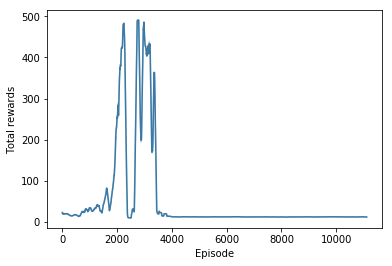

In [31]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

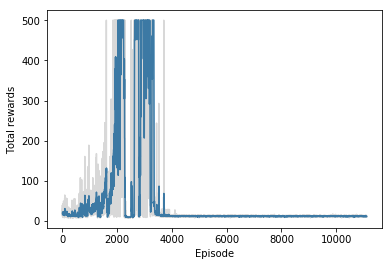

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

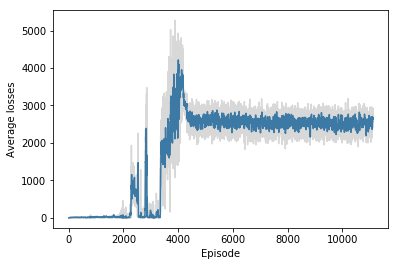

In [33]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    
    # Episode/epoch
    for _ in range(1):
        state = env.reset()
        total_reward = 0
        
        # Steps/batches
        while True:
            env.render()
            action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                    feed_dict = {model.states: state.reshape([1, -1]), 
                                                                 model.initial_state: initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # At the end of each episode
        print('total_reward:{}'.format(total_reward))

# Close the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.